# T cells mapped to T2T version 2.0
# Day 6 post EP for CRISPoff and unedited
# Pipeline to Extract and Analyze mC profiles from BAM files and look at Forward & Reverse strands

Date: Sept. 10, 2025
Modify the window of the input size

Save subsets of reads

In [1]:
import sys
from pathlib import Path
from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
# import time
# import shap


# Add the folder containing 'my_functions.py' to sys.path
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))

# Import the module or specific functions
# from /home/michalula/code/epiCausality/epiCode/utils/funcs_extract_mC_profiles_from_BAMs.py
# from funcs_extract_mC_profiles_from_BAMs import system_info, extract_from_bam
from funcs_extract_mC_profiles_from_BAMs import (
    system_info,
    get_reference_sequence,
    create_output_directory,
    extract_from_bam,
    process_extracted_reads,
    visualize_data,
    create_padded_reads,
    plot_padded_reads,
    save_padded_reads,
    remove_low_methylated_reads,
    process_extracted_reads_no_fully_unmethylated,
    create_padded_reads_no_fully_unmethylated,
    subset_BAM_by_read_IDs,
    bam_to_sam,
    plot_bam_quality_metrics
    # main,
)
from funcs_analize_forward_reverse_extracted_mC_reads import analize_forward_reverse_CGs_pipeline

from funcs_check_quality_bams import get_read_info_by_index, get_read_info_by_name

modkit found with expected version 0.2.4


In [2]:
system_info()
date_today = datetime.today().strftime('%Y-%m-%d')
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta')
reg_genome_version = "t2t_v2_0"
region_chr = 'chr1'

# 6500bps: EXACT cutting region  
# chr1:206,583,334-206,589,873
region_start = 206583334    + 20
region_end = 206589874      - 20 
# CD55 TSS start: chr1:206586828-206606065 (+)
# (before TSS: 3474, after TSS: 3026 bps)

region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
region_length = region_end - region_start
print("region_length", region_length)


motifs=['CG,0']
ref_seq_list = get_reference_sequence(ref_genome_path, region_chr, region_start, region_end)

print('region_chr', region_chr)
print('region_start', region_start)
print('region_end', region_end)
print(f'{region_chr}:{region_start}-{region_end}') 

System: Linux
Release: 6.8.0-79-generic
Version: #79~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Aug 15 16:54:53 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
region_length 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTA

# Look at Cas9 T cells at day 6 post EP  



In [3]:
day_num = 28
day_num

28

In [4]:
output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output'
# '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/output/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
output_dir_path


'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output'

In [5]:
original_bam_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

original_bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

experiment_name =  day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowc…

          |    0%

          | Transferring 28 from reads.CG,0.txt into reads.combined_basemods.h5, new size 28   0% | 00:00<?

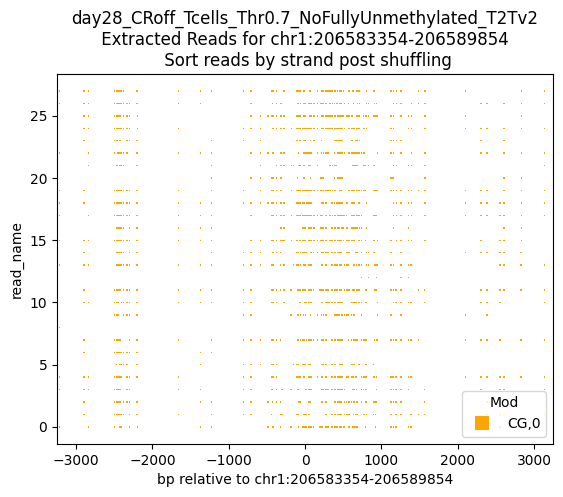

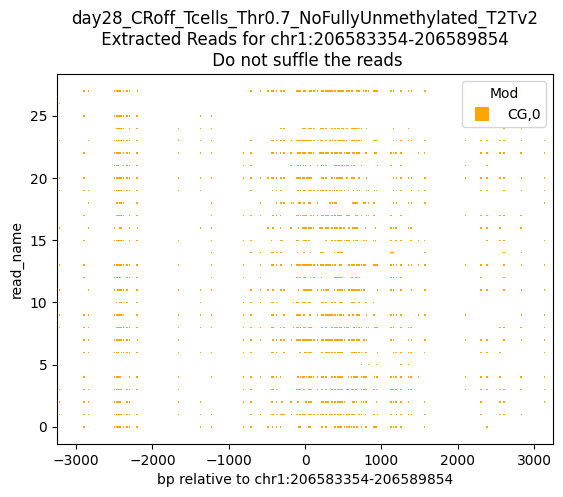

Found read coordinates: 28 reads
Unique read names with methylation: 28
In function count_indels_and_mismatches: Processing region is chr1:206583354-206589854
In function count_indels_and_mismatches: Region length is 6500
Found 13 reads with full coverage
Reads with methylation data: 28
Overlap between full coverage and methylation: 13
After full coverage filtering: 13 reads with methylation data
Subset BAM written to: dimelo_v2_output/pre_filtered_ROI_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam
Index written to: dimelo_v2_output/pre_filtered_ROI_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam.bai
Pre Filtered BAM with reads that have some covarage of the ROI written to 
 pre_filtered_ROI_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam


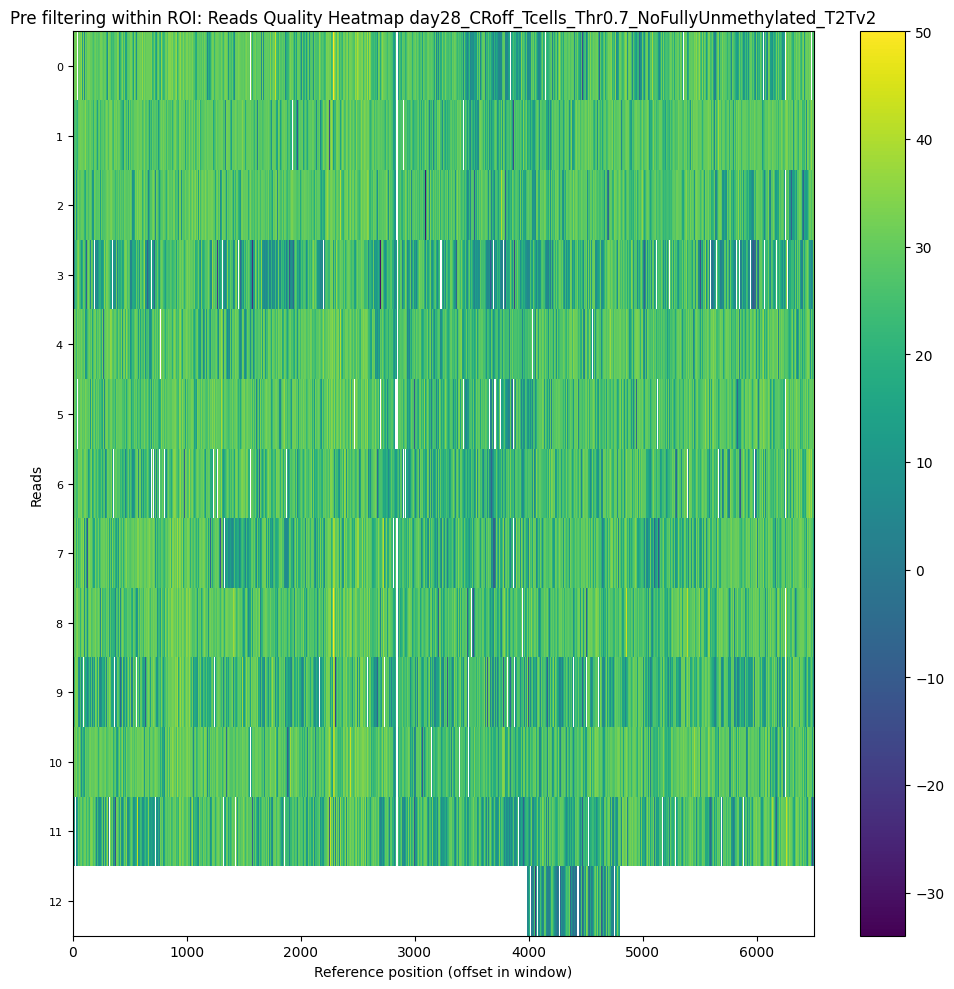

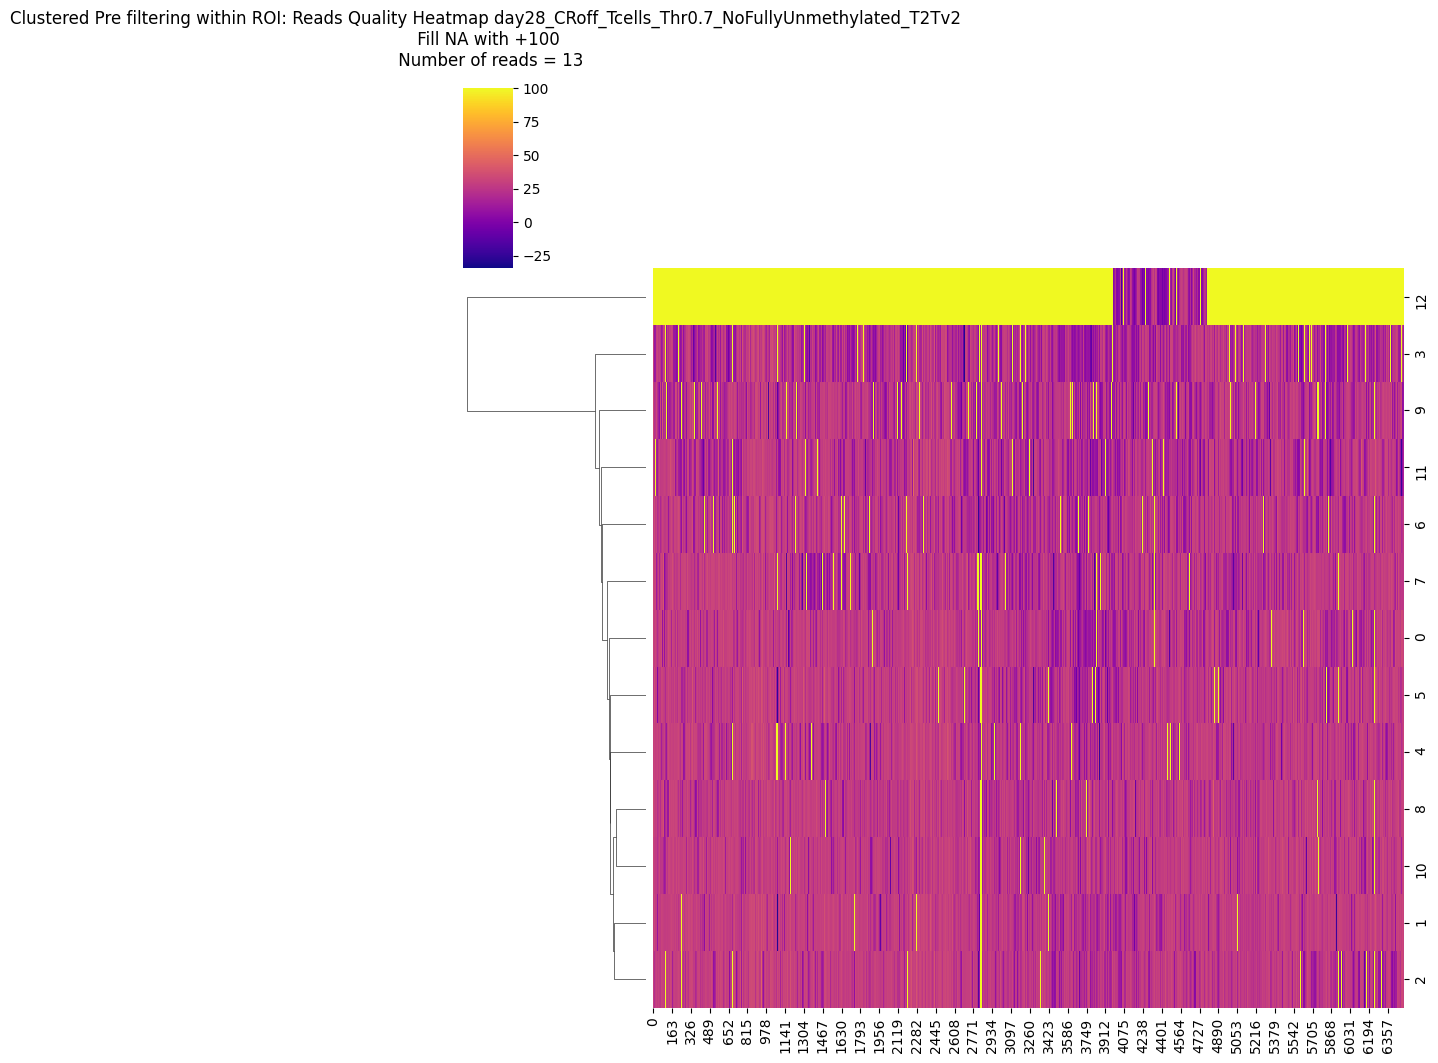

After removing reads with <90.0% threshold_fraction_overlap_aligned: 12 reads with methylation data
After removing reads with >70.0% threshold_fraction_mismatches: 12 reads with methylation data
After removing reads with >60 threshold_mapping_qualities: 12 reads with methylation data
After removing reads with >20 threshold_avg_base_qualities: 11 reads with methylation data
Final result: 798 reads with methylation information out of 28 total reads
Subset BAM written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam
Index written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam.bai
Filtered BAM with reads that have mC and base overlap > 0.9 written to 
 dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam


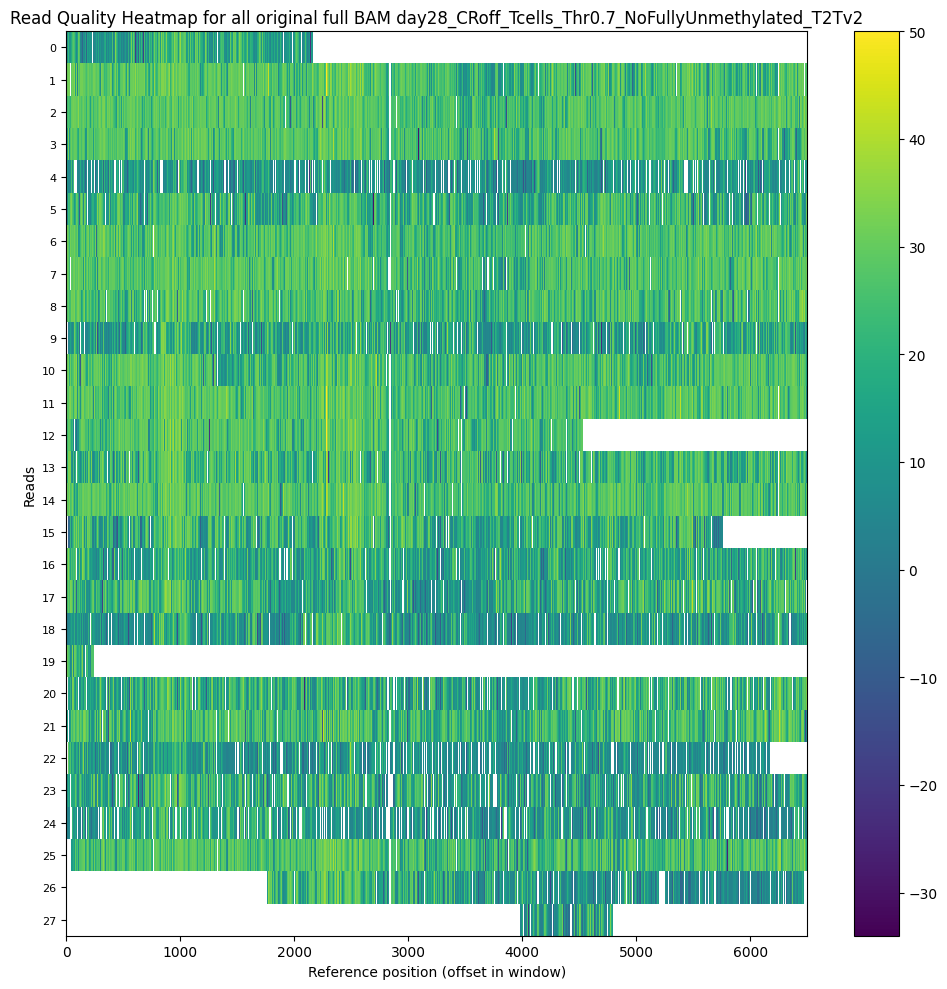

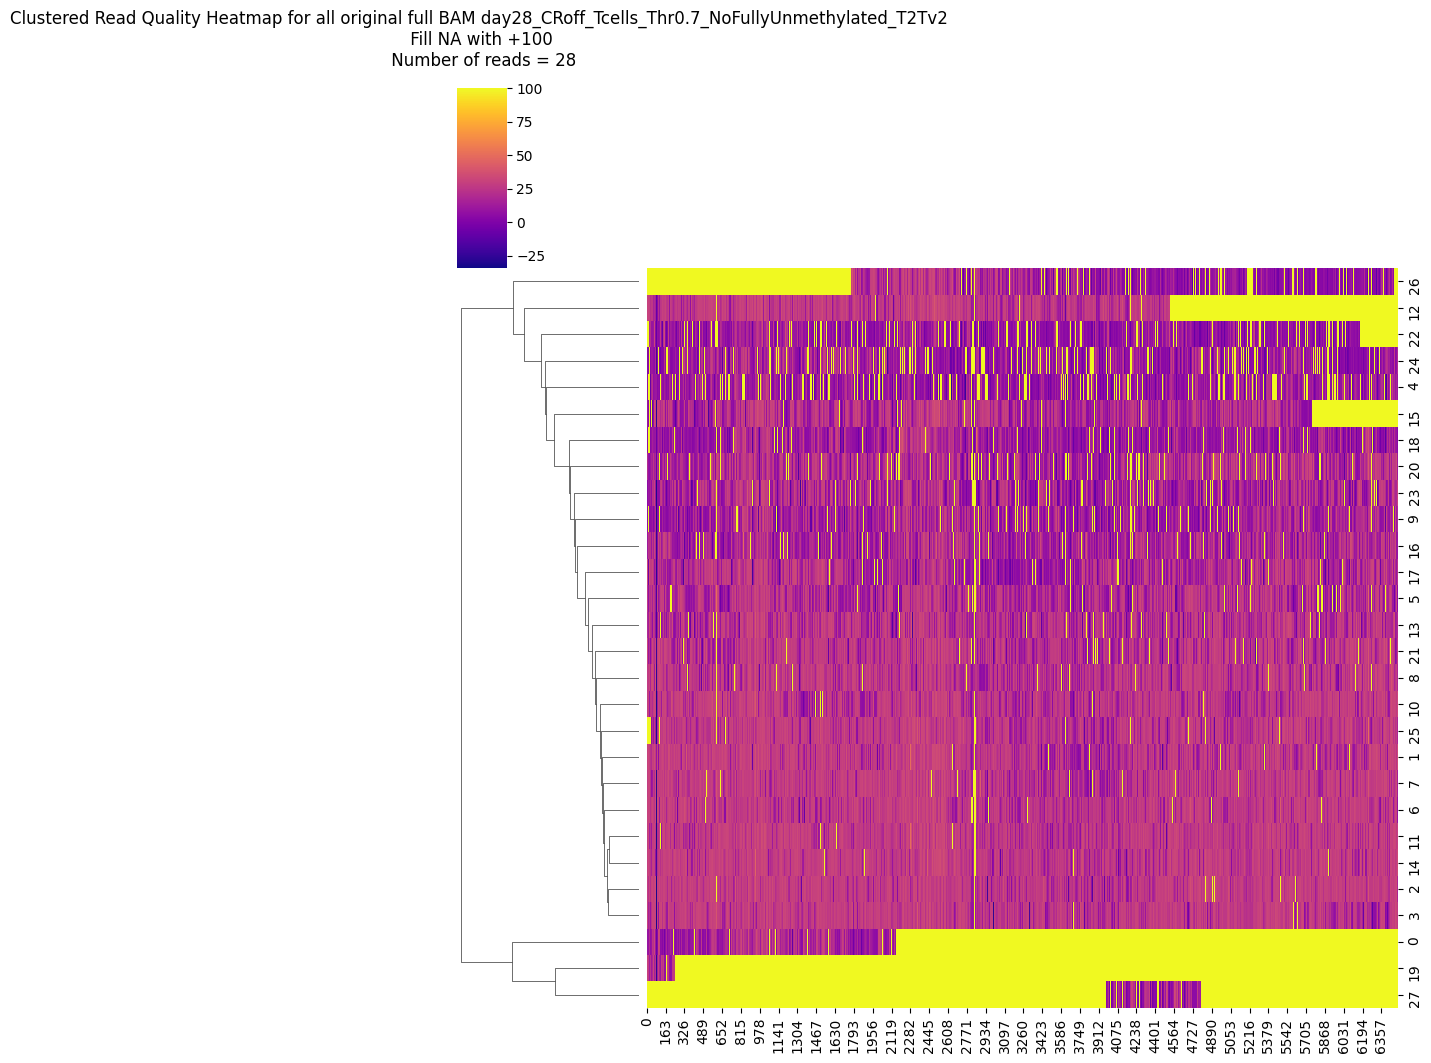

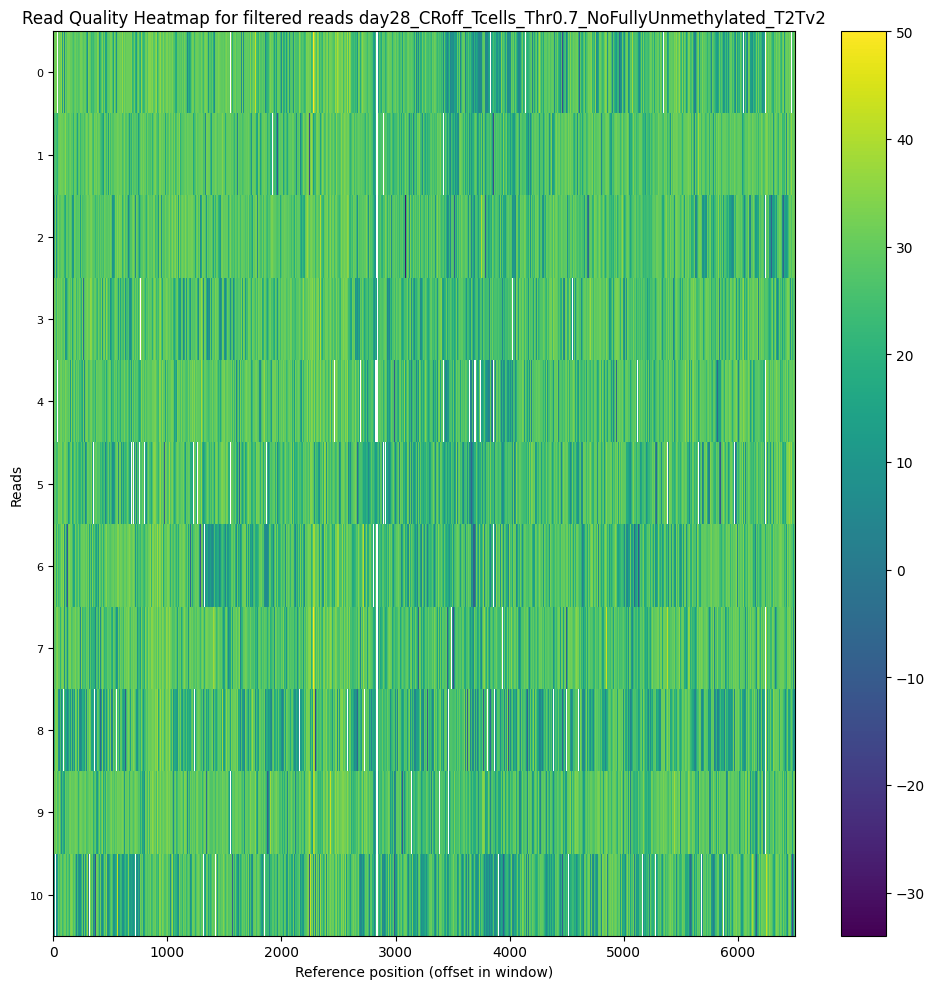

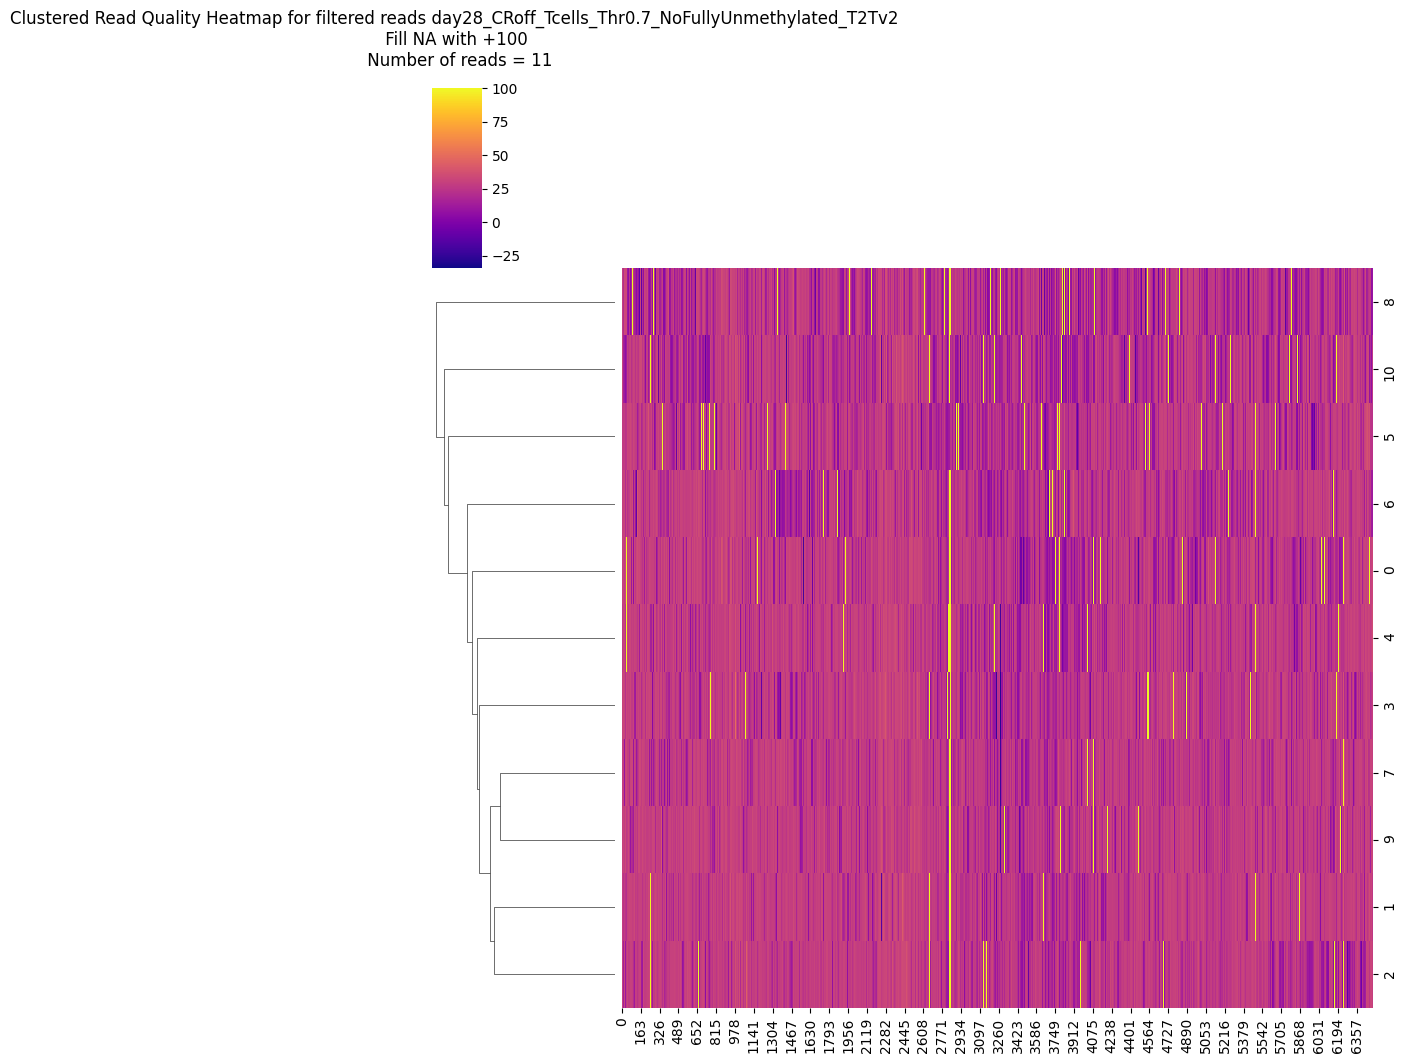

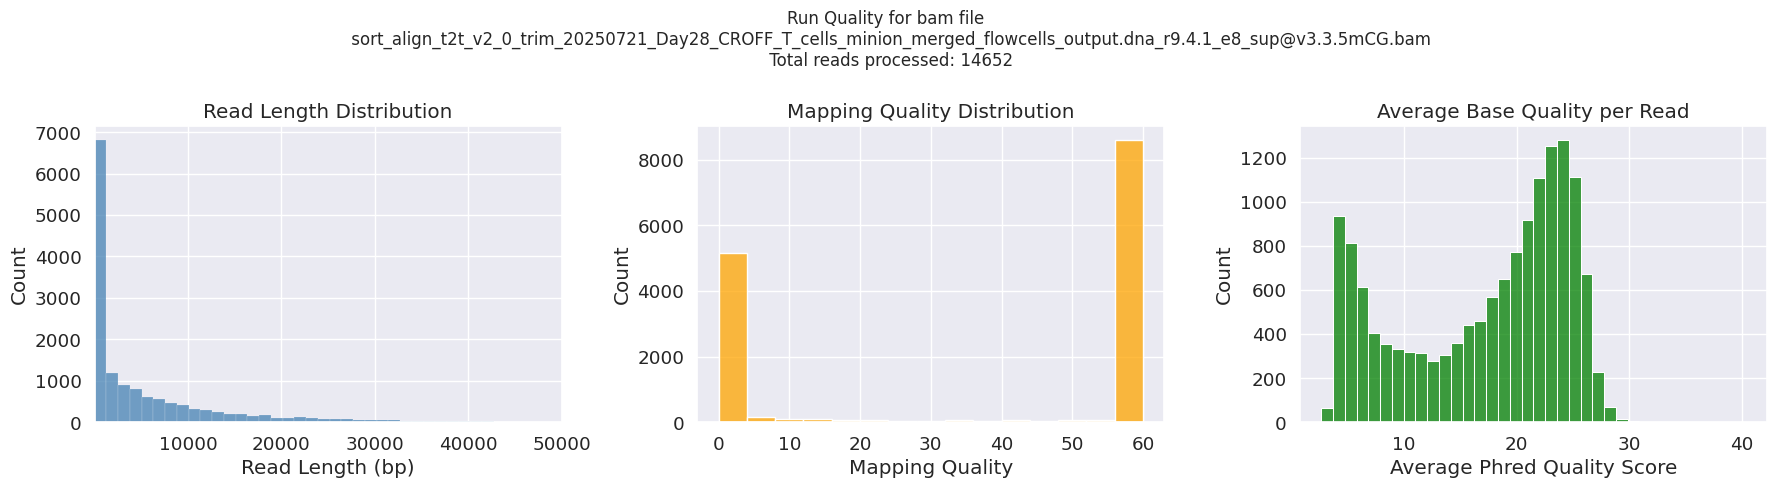

Total reads processed: 14652


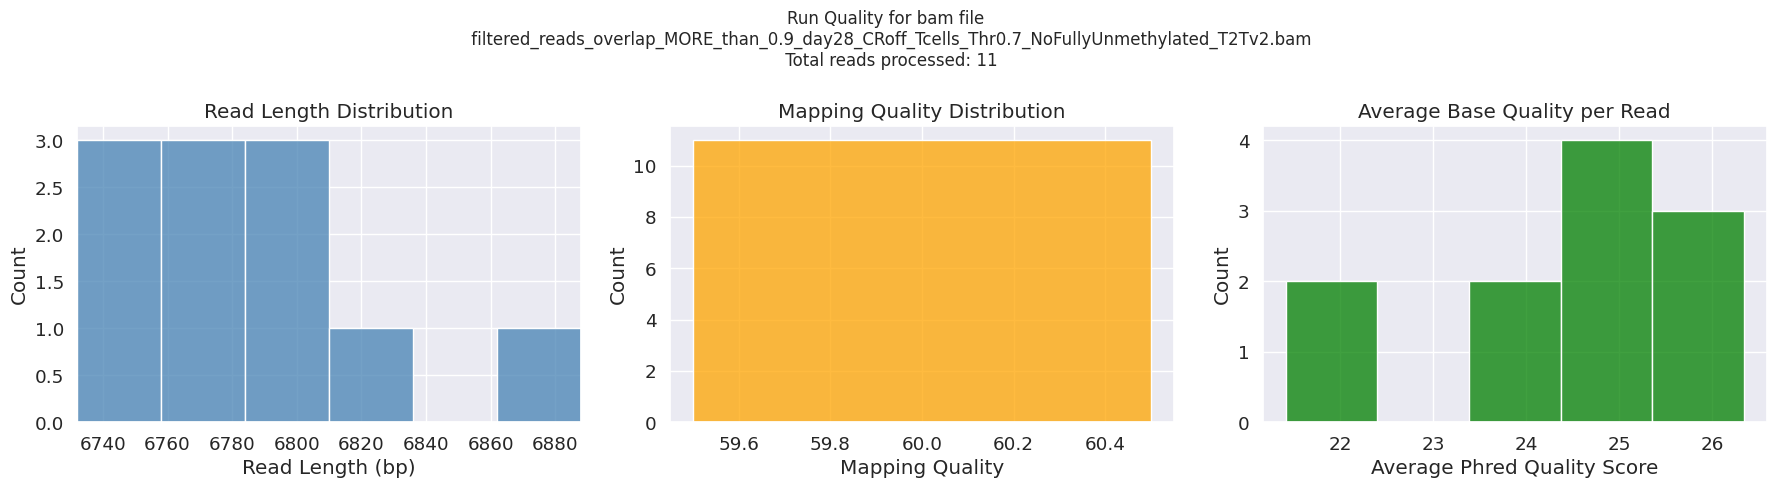

Total reads processed: 11


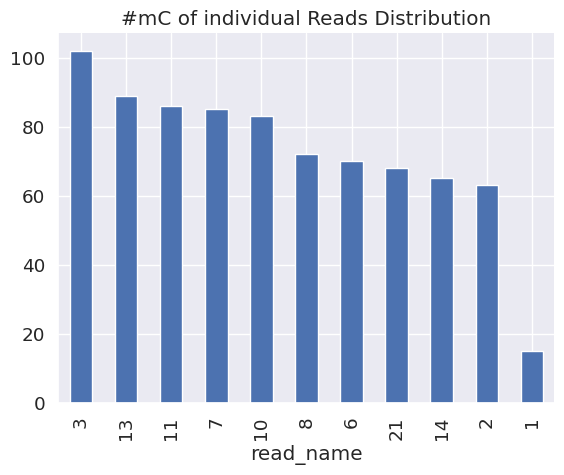

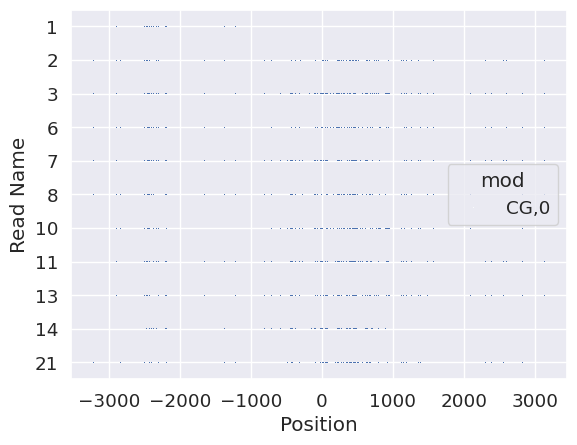

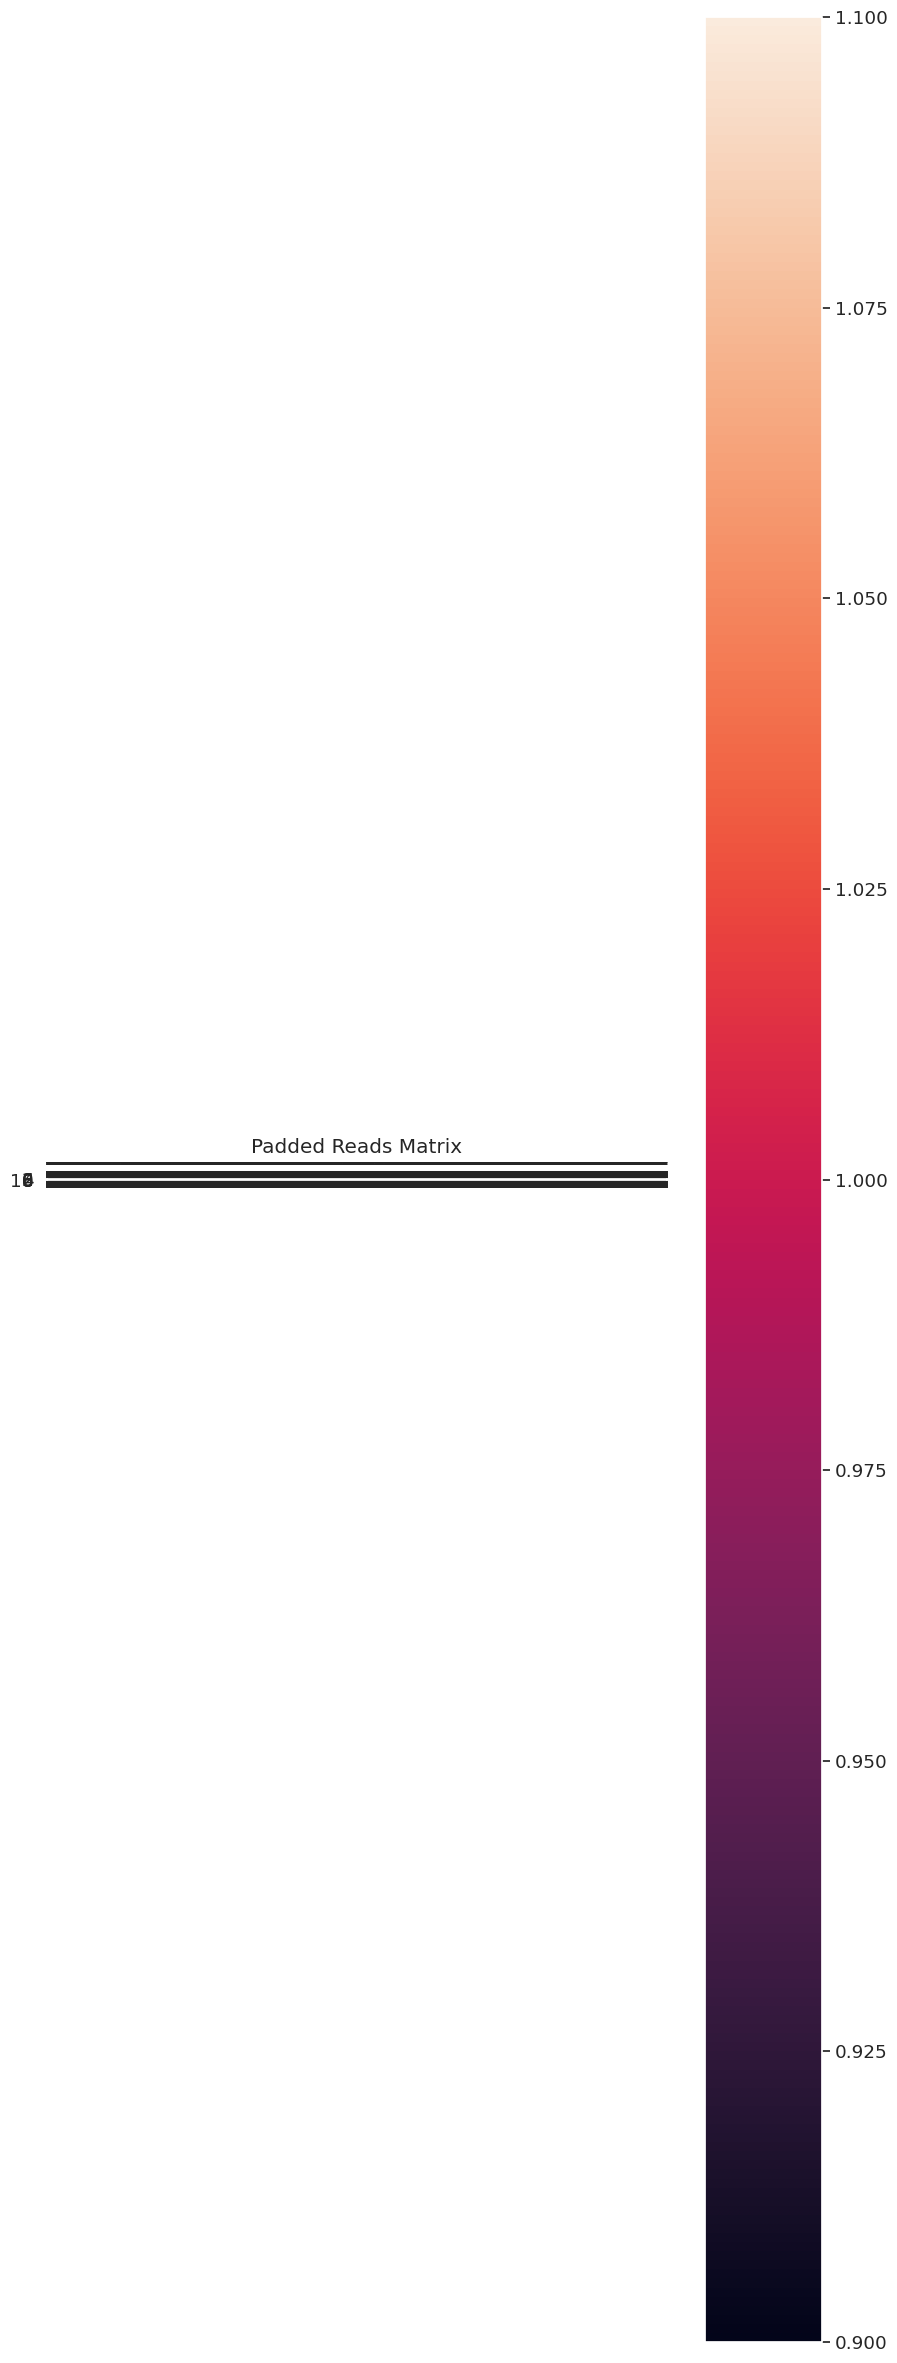

Padded reads saved to padded_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-10.npy
Padded reads loaded successfully.


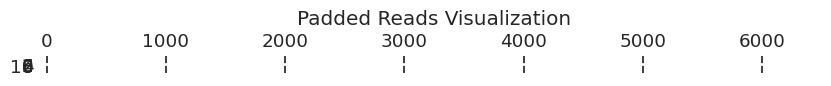

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

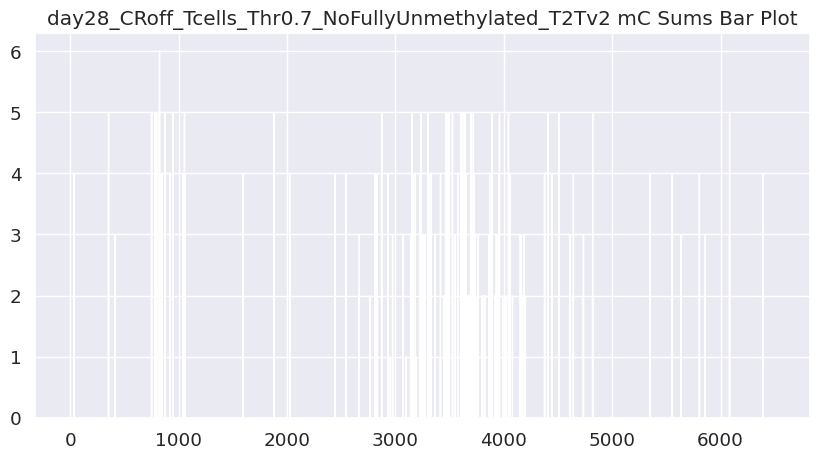

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


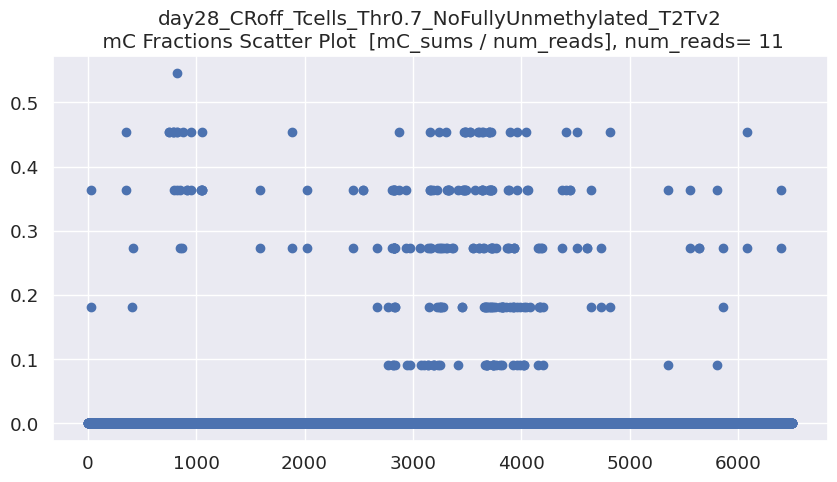

len(CGs_all) = 11
CGs_all.shape = (11, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


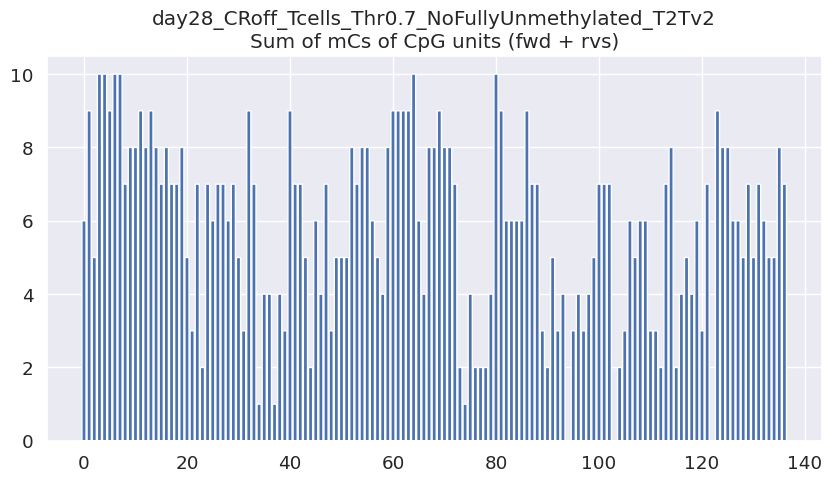

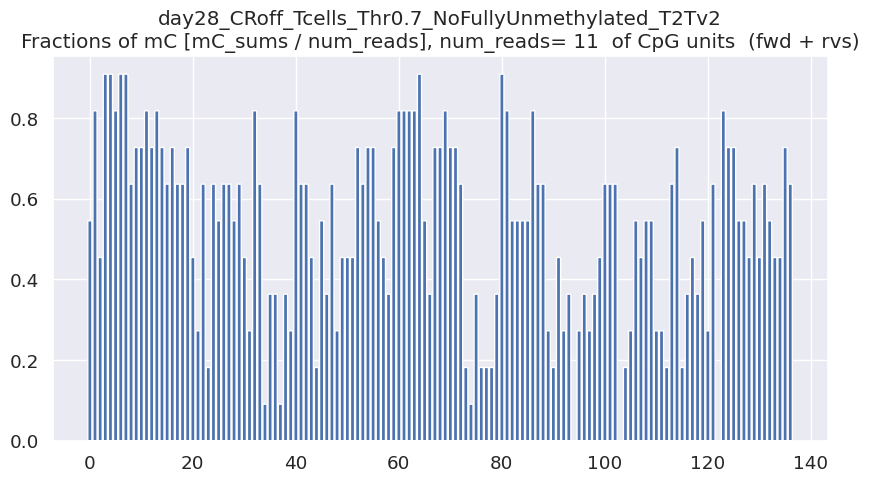

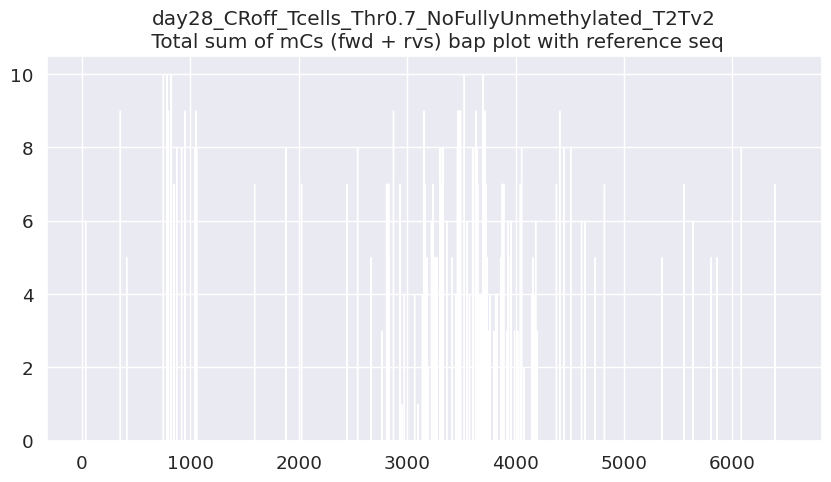

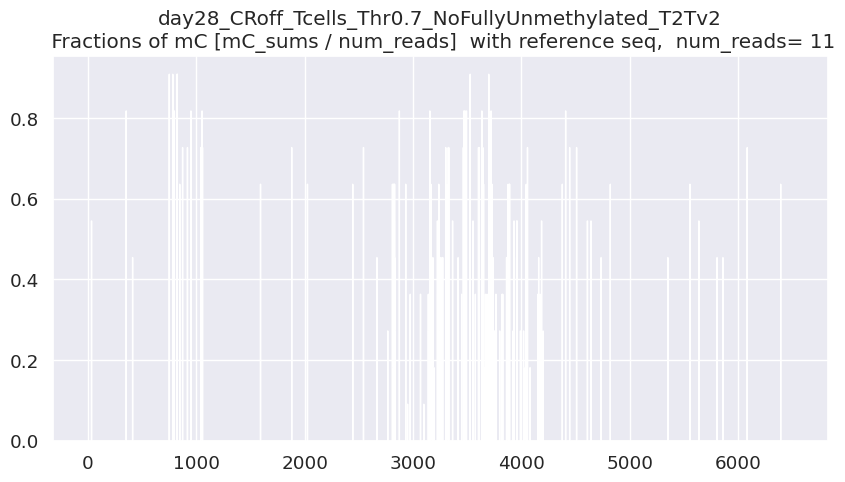

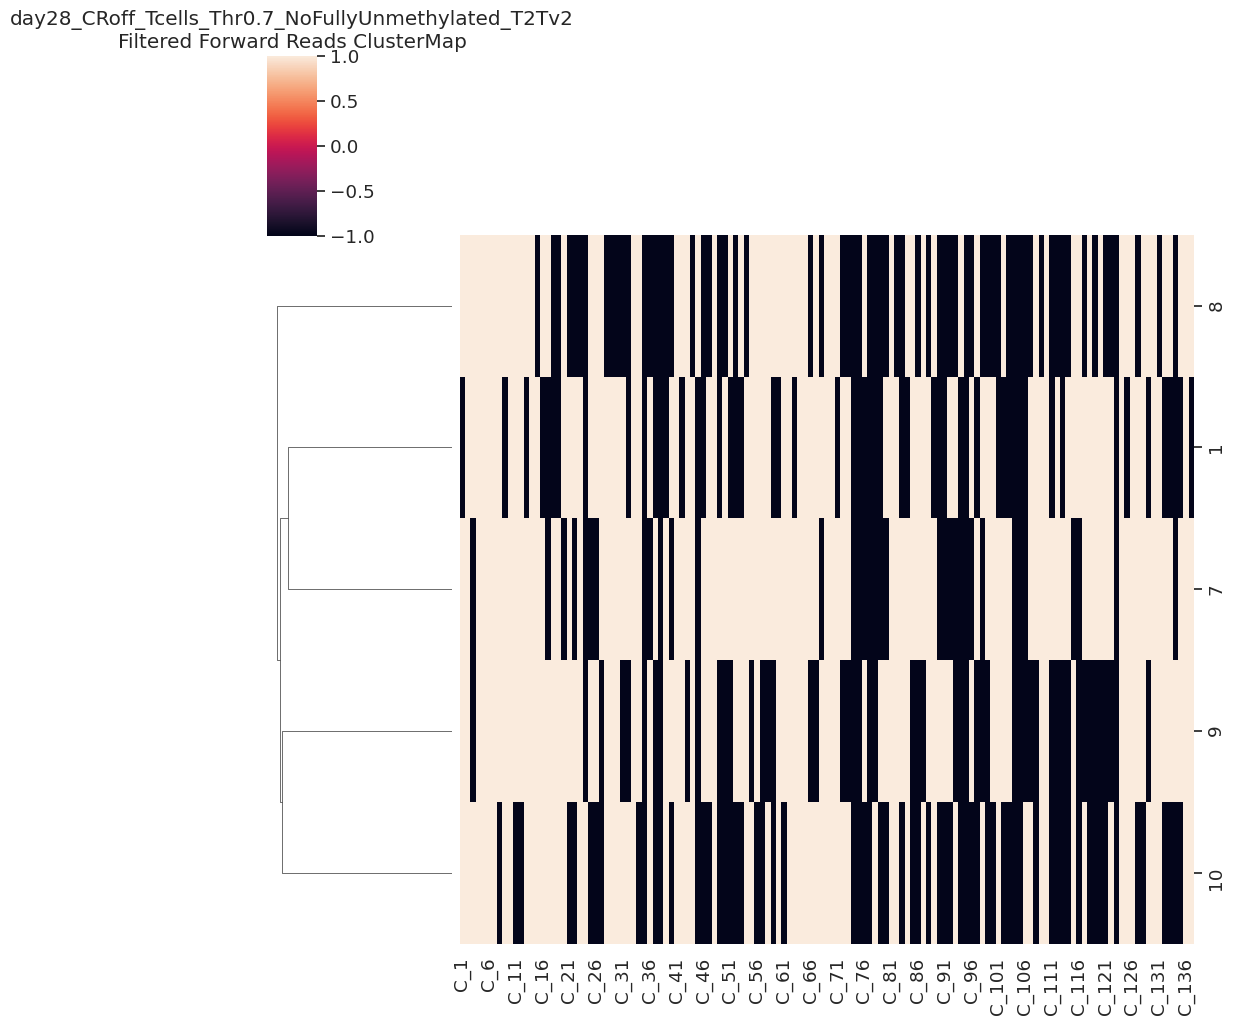

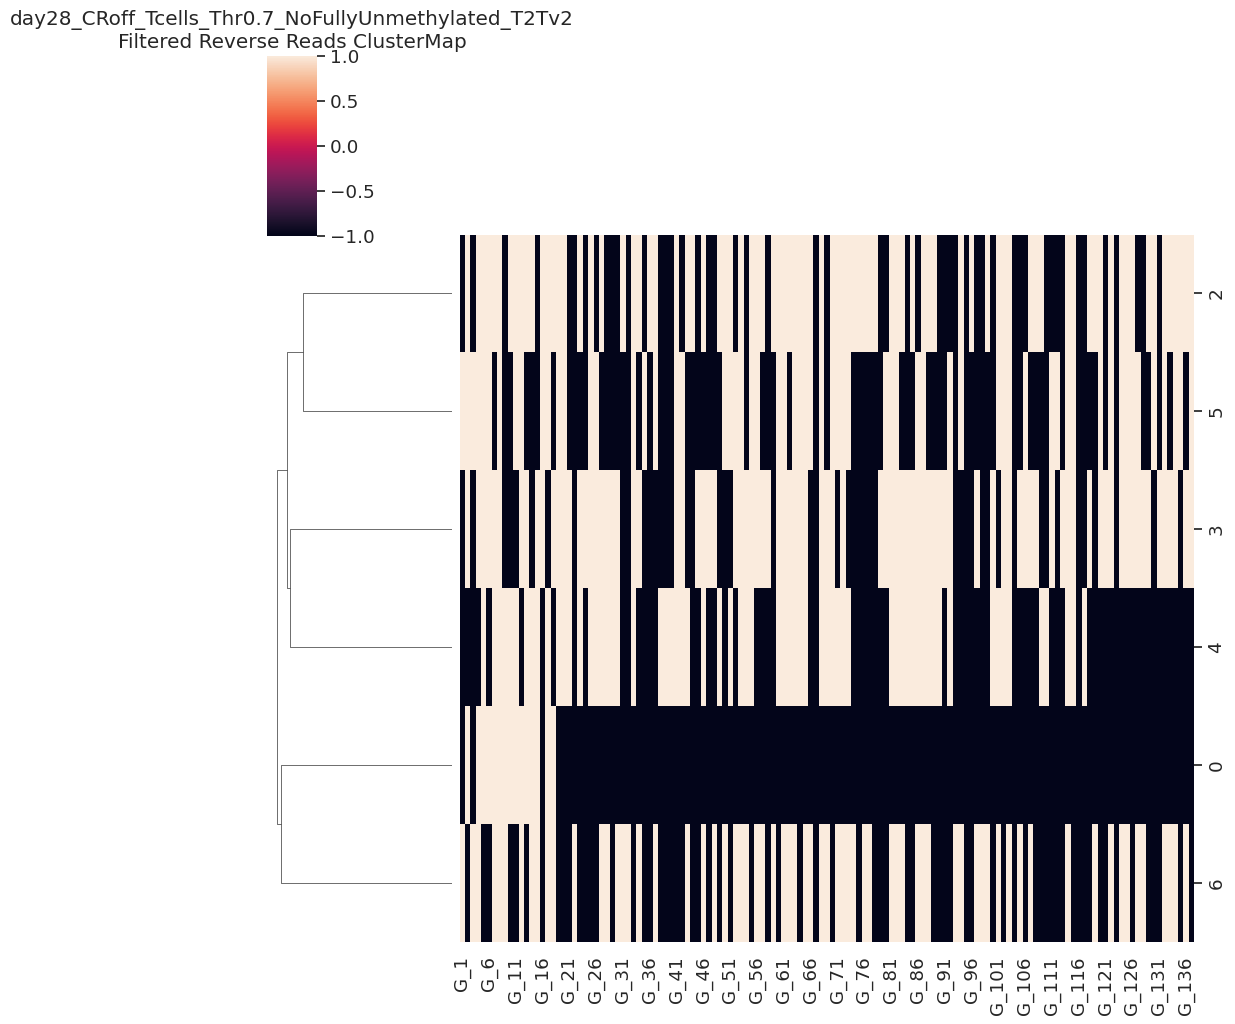

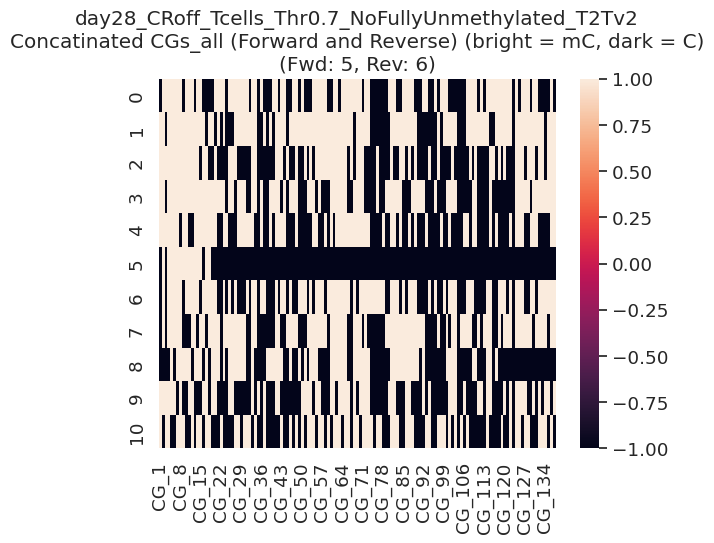

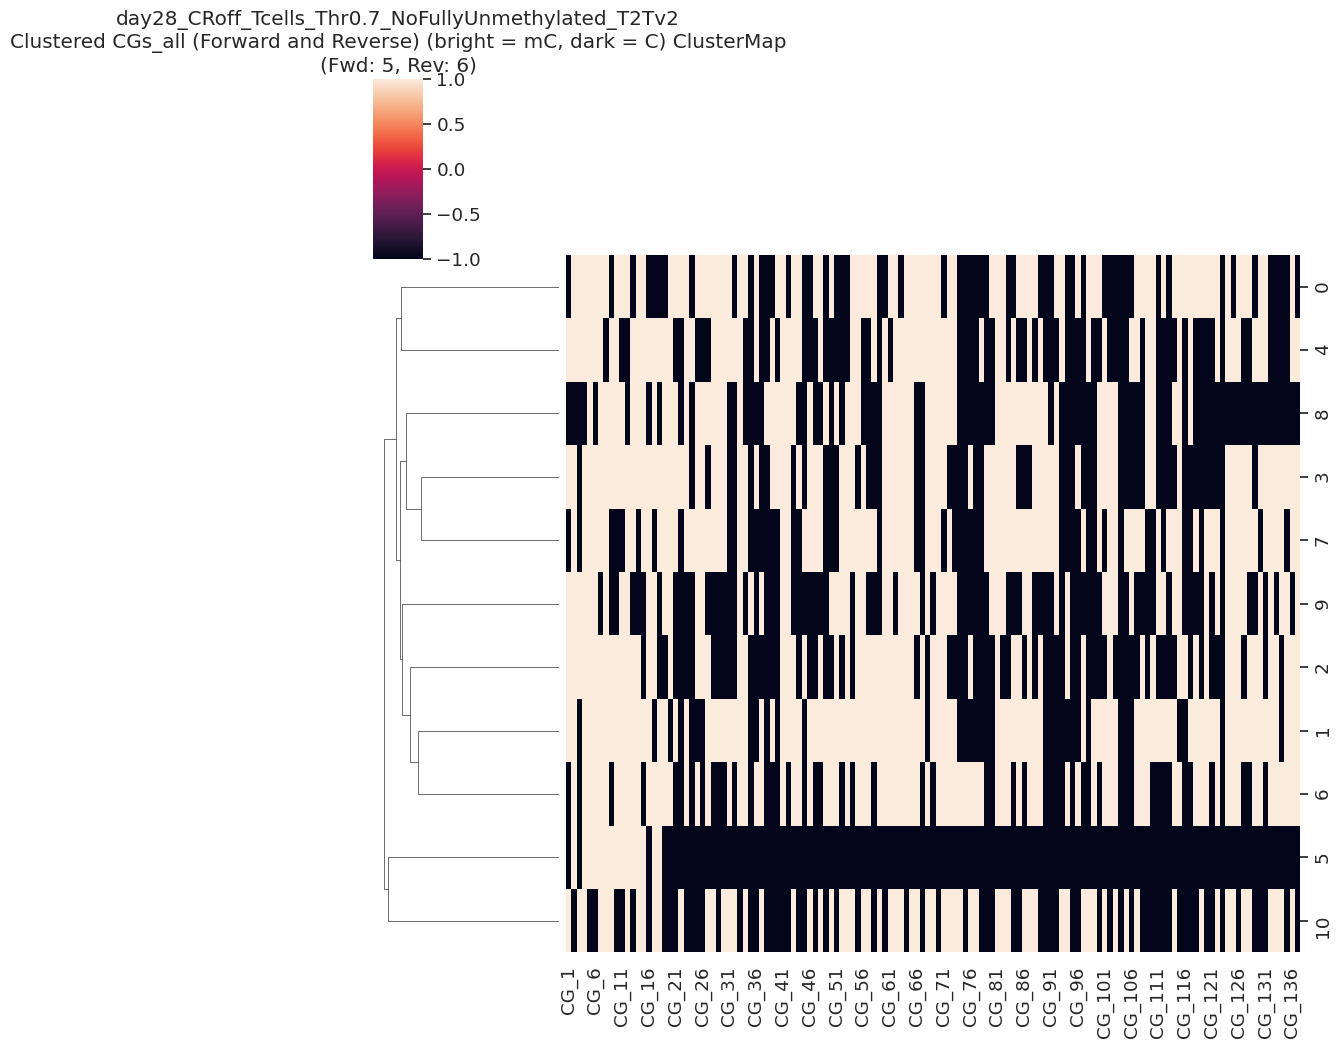

CGs_all saved as CG_137_padded_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-10_units_combined_numFWD5_numRVS6.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [6]:
threshold_mC = 0.7 # 0.995 #0.7 #  0.9 #0.99

max_reads_plot = 3000

threshold_mapping_qualities=60 
threshold_avg_base_qualities=20

threshold_fraction_overlap_aligned = 0.9 # 0.1
threshold_fraction_mismatches = 0.7 # 0.5
# indel_fraction_threshold = 1  # 0.8
# non_fraction_threshold   = 1

# experiment_name = "day"+str(day_num)+"_unedited_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
experiment_name = "day"+str(day_num)+"_CRoff_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"

bam_path = original_bam_path #  unedit_bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    region=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, bam_path, region_str, 
        motifs, ref_seq_list, ref_genome_path=ref_genome_path, 
        experiment_name=experiment_name, output_dir=output_dir, 
        keep_full_coverage_reads_only=keep_full_coverage_reads_only,
        threshold_fraction_overlap_aligned=threshold_fraction_overlap_aligned,
        threshold_fraction_mismatches=threshold_fraction_mismatches,
        threshold_mapping_qualities=threshold_mapping_qualities, 
        threshold_avg_base_qualities=threshold_avg_base_qualities,
        max_reads_plot=max_reads_plot)
        # indel_fraction_threshold=indel_fraction_threshold, 
        # non_fraction_threshold=non_fraction_threshold)
        
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


experiment_name =  day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.995 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowc…

          |    0%

          | Transferring 28 from reads.CG,0.txt into reads.combined_basemods.h5, new size 28   0% | 00:00<?

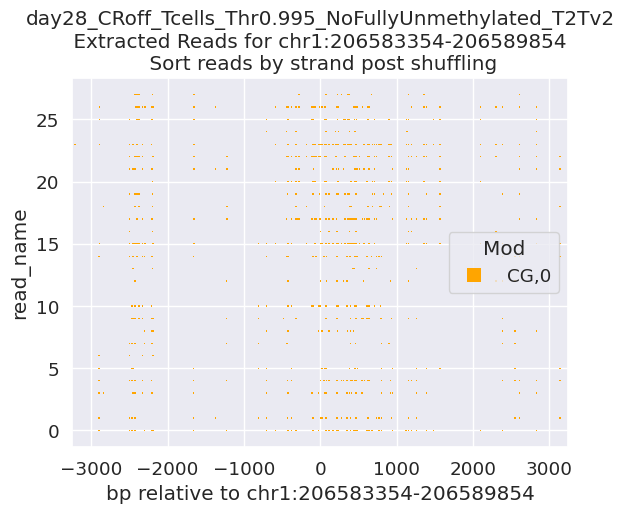

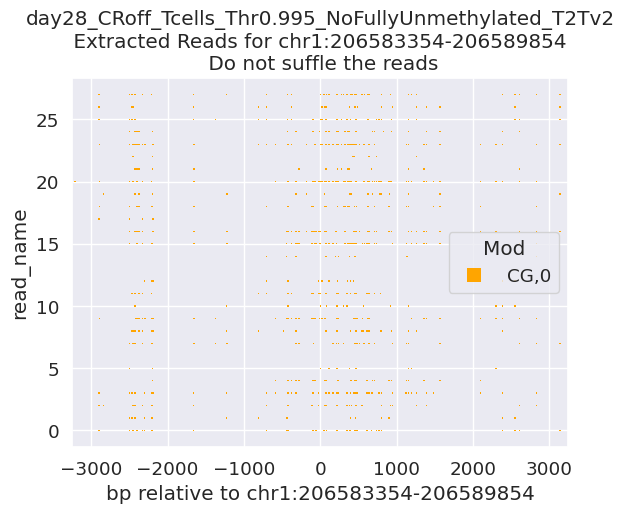

Found read coordinates: 28 reads
Unique read names with methylation: 26
In function count_indels_and_mismatches: Processing region is chr1:206583354-206589854
In function count_indels_and_mismatches: Region length is 6500
Found 13 reads with full coverage
Reads with methylation data: 26
Overlap between full coverage and methylation: 13
After full coverage filtering: 13 reads with methylation data
Subset BAM written to: dimelo_v2_output/pre_filtered_ROI_reads_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam
Index written to: dimelo_v2_output/pre_filtered_ROI_reads_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam.bai
Pre Filtered BAM with reads that have some covarage of the ROI written to 
 pre_filtered_ROI_reads_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam


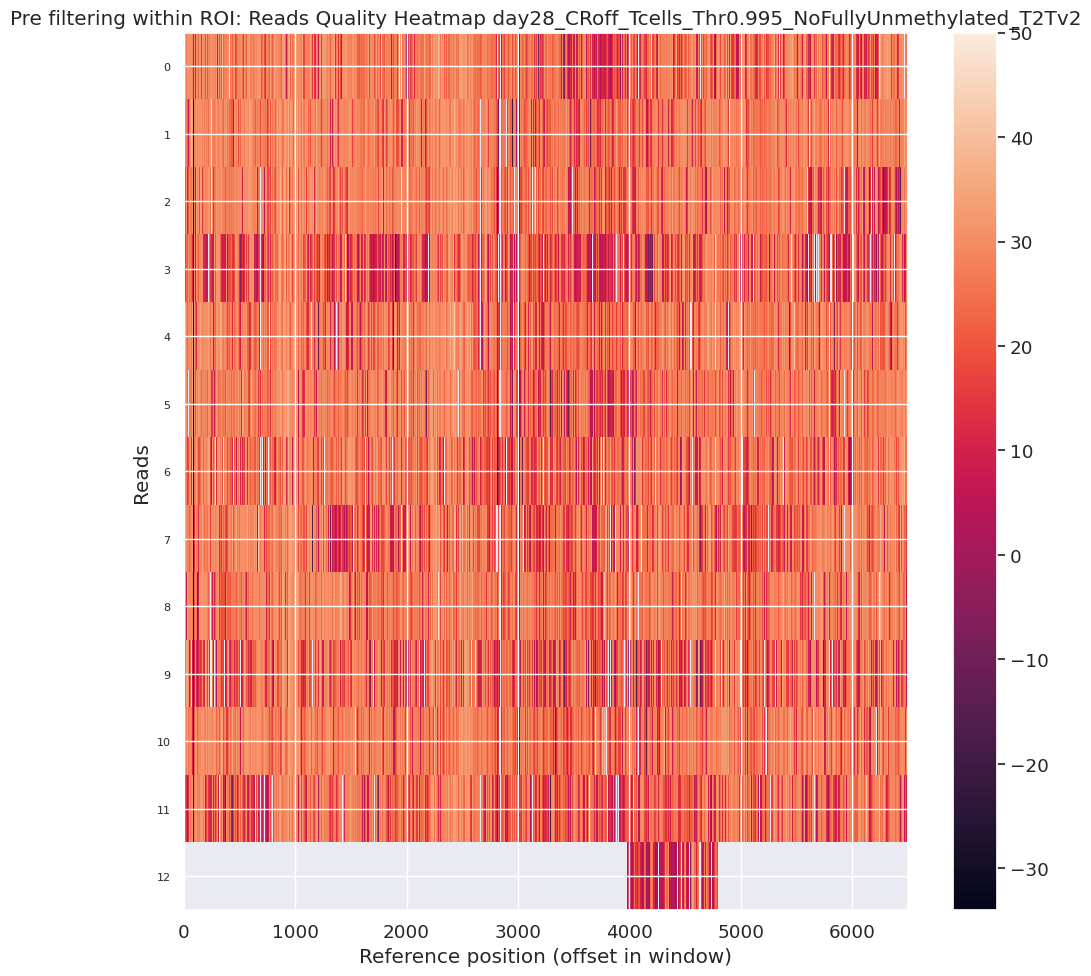

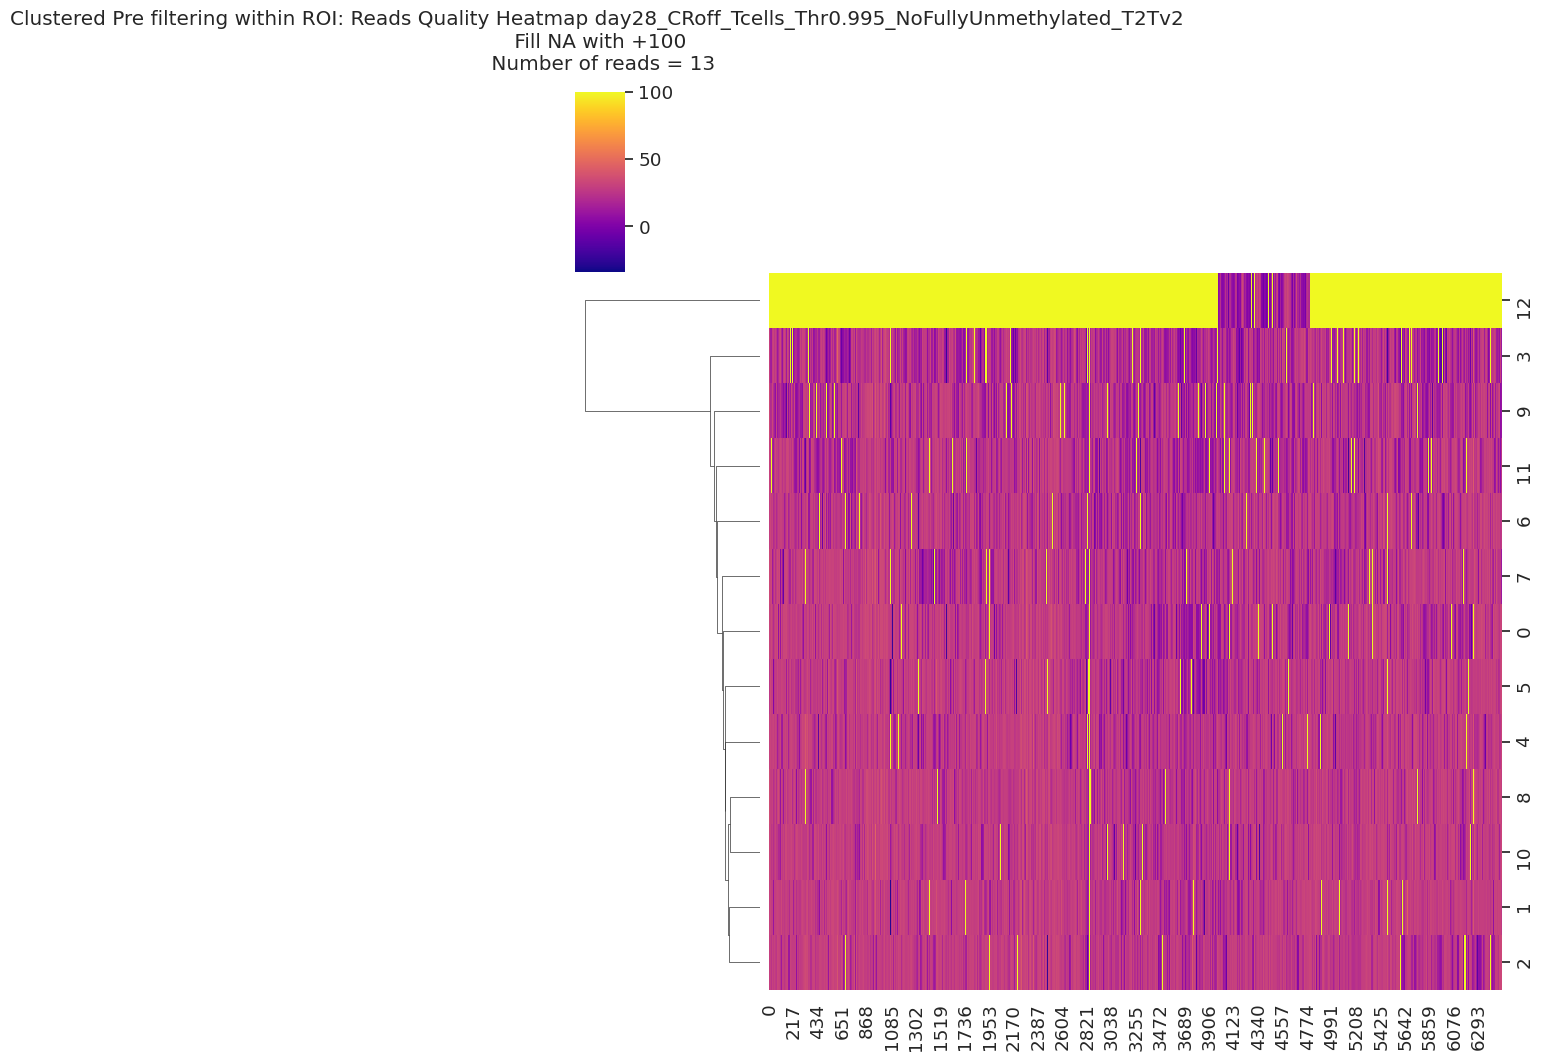

After removing reads with <90.0% threshold_fraction_overlap_aligned: 12 reads with methylation data
After removing reads with >70.0% threshold_fraction_mismatches: 12 reads with methylation data
After removing reads with >60 threshold_mapping_qualities: 12 reads with methylation data
After removing reads with >20 threshold_avg_base_qualities: 11 reads with methylation data
Final result: 401 reads with methylation information out of 28 total reads
Subset BAM written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam
Index written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam.bai
Filtered BAM with reads that have mC and base overlap > 0.9 written to 
 dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam


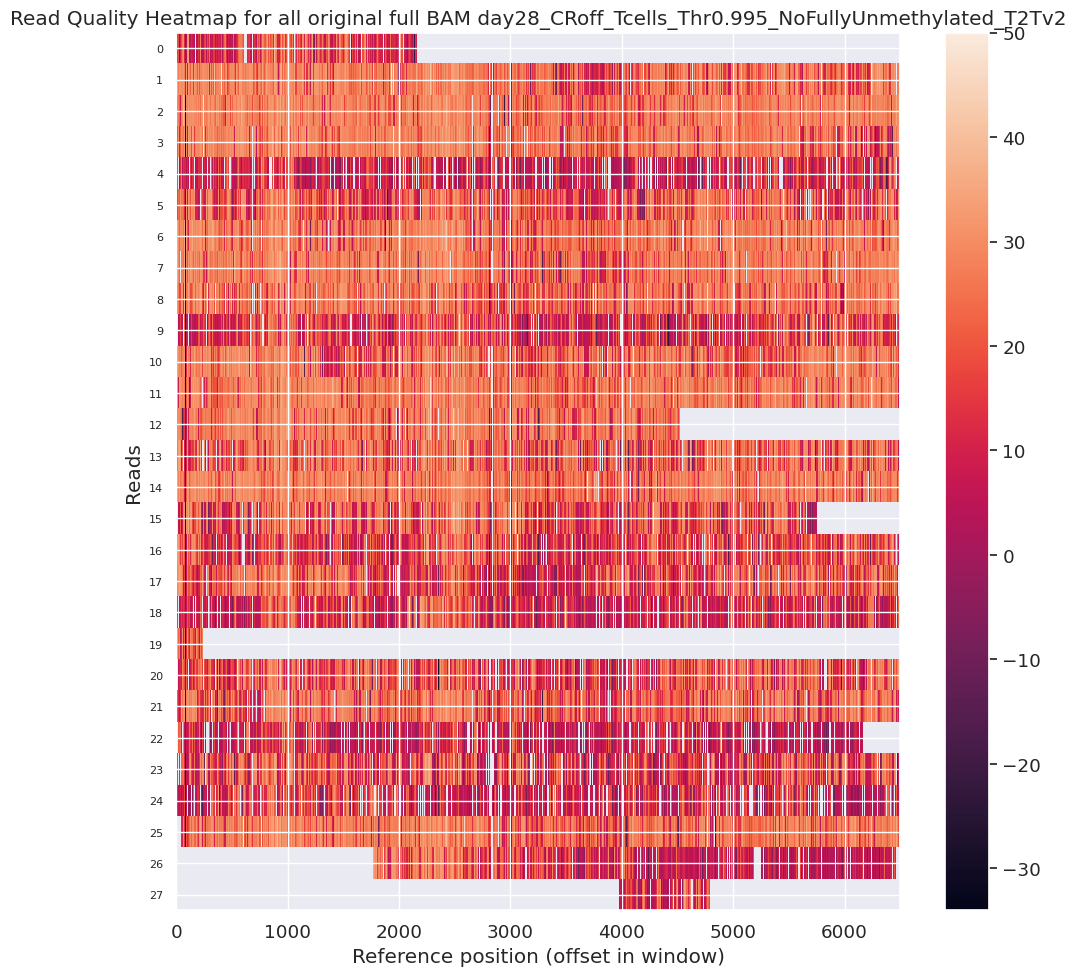

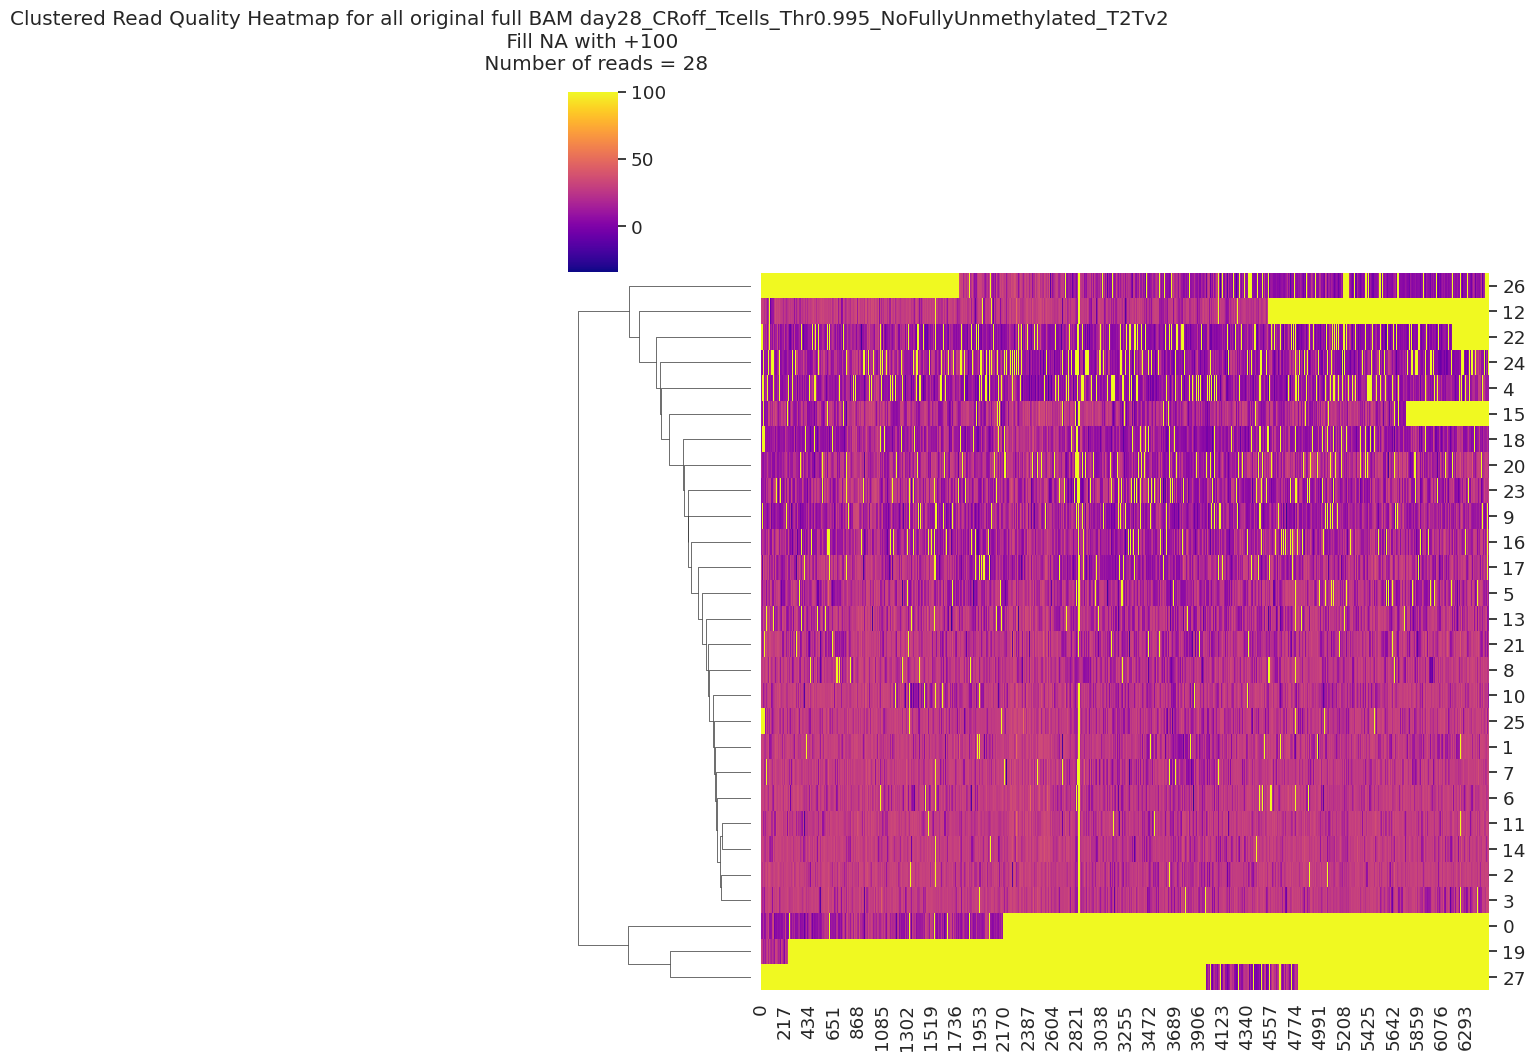

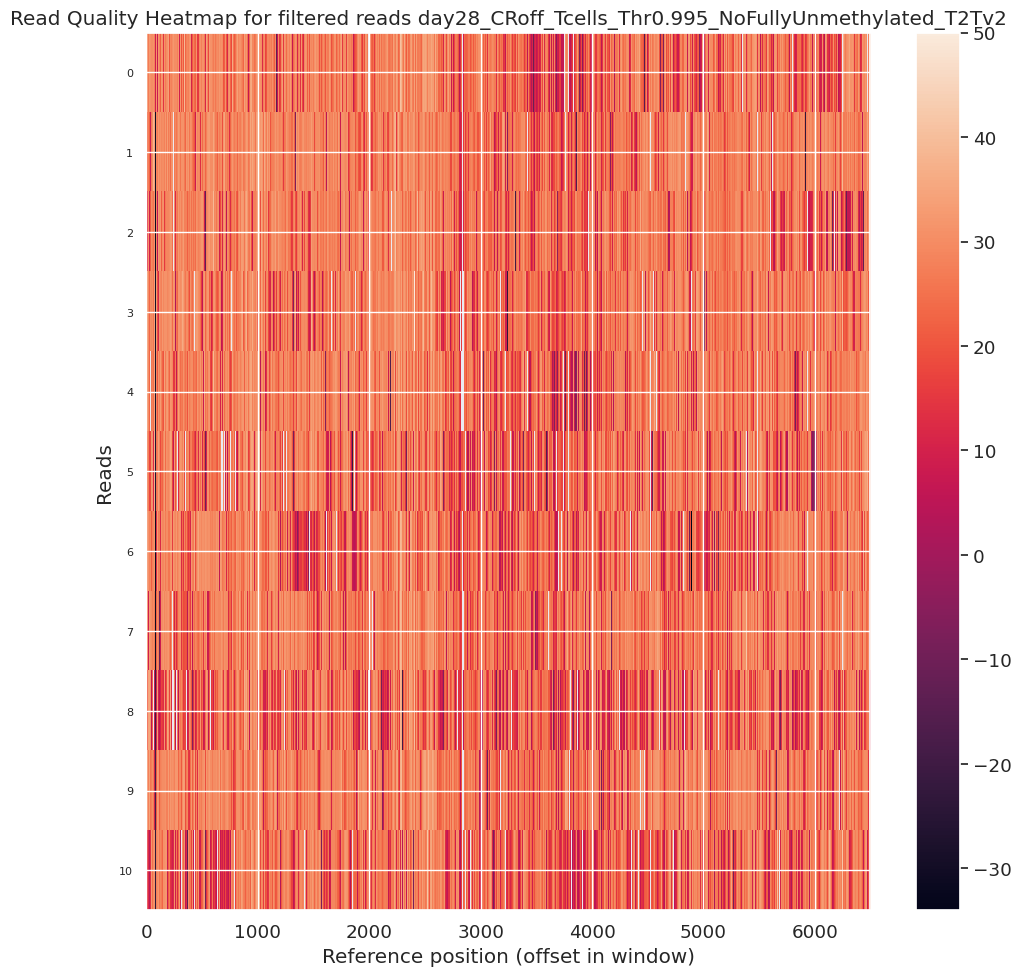

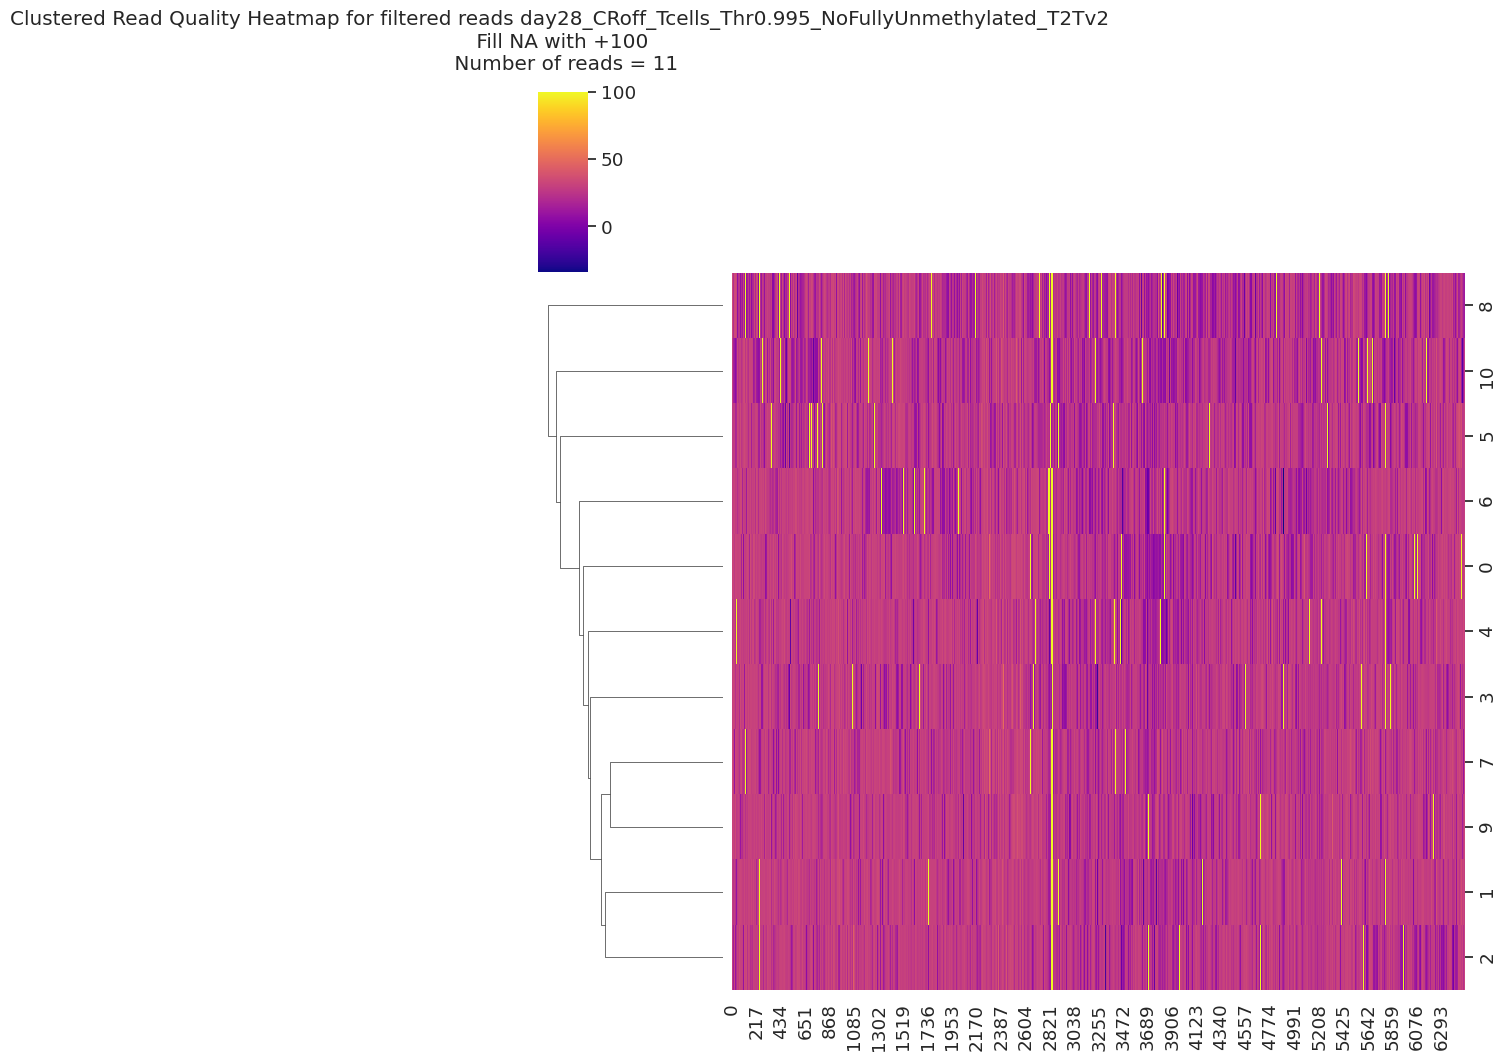

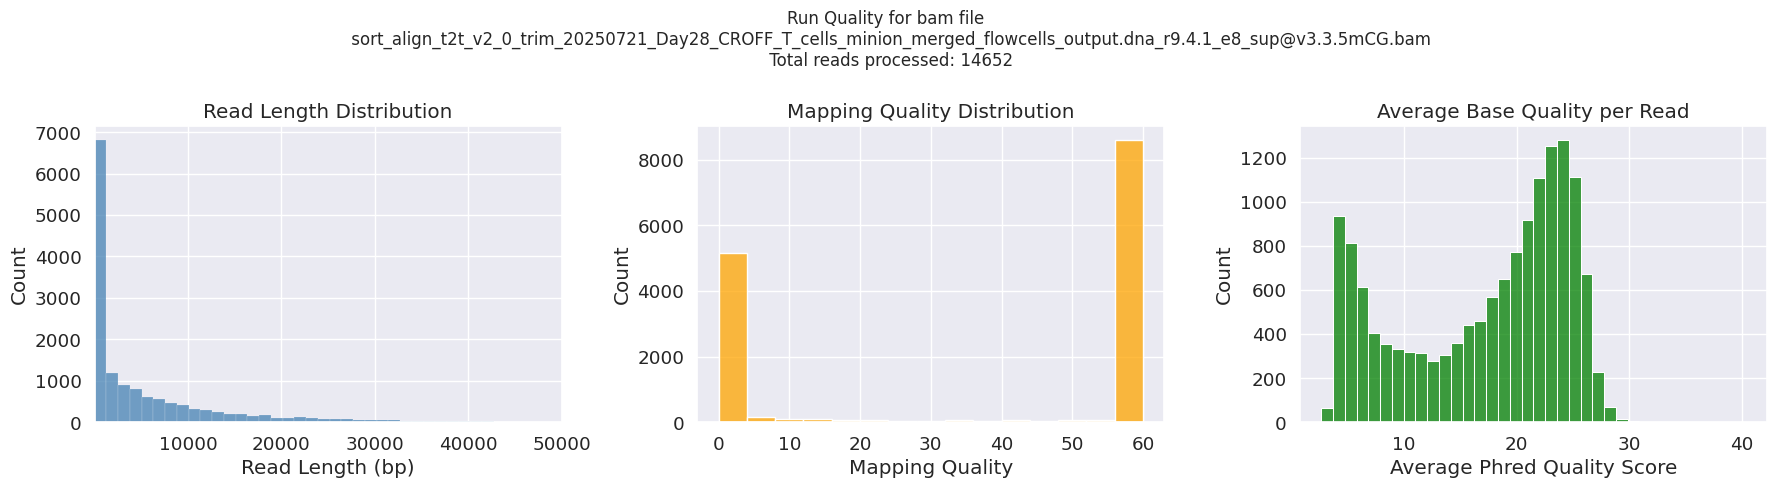

Total reads processed: 14652


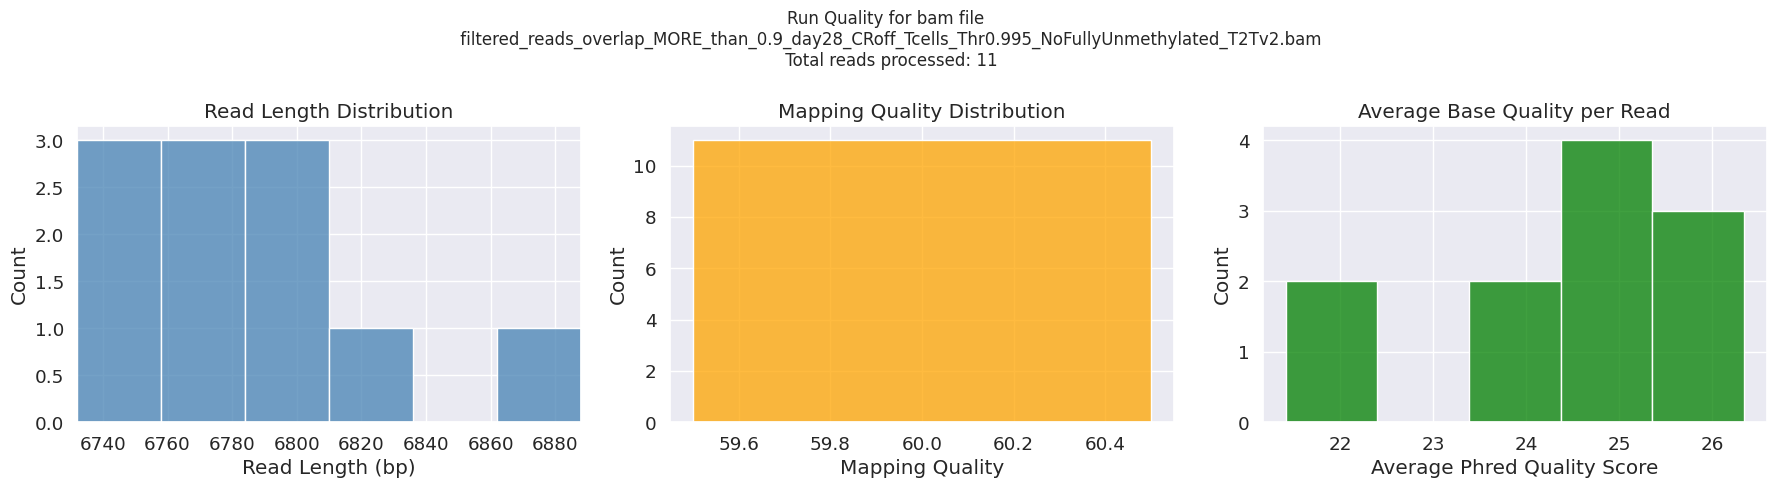

Total reads processed: 11


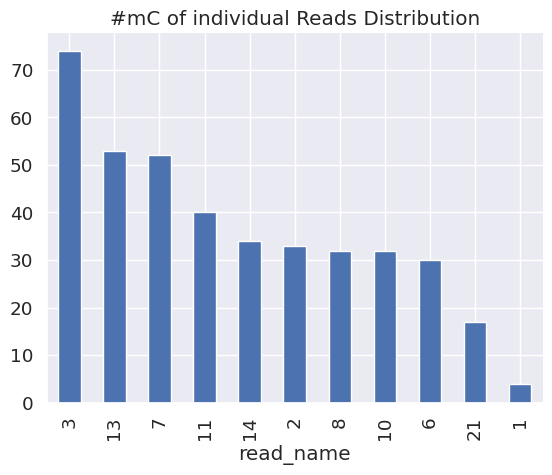

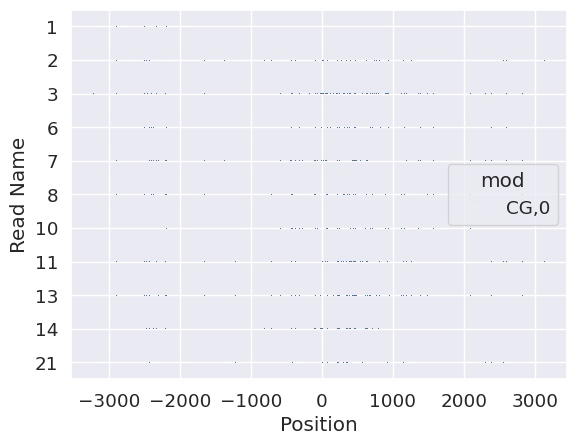

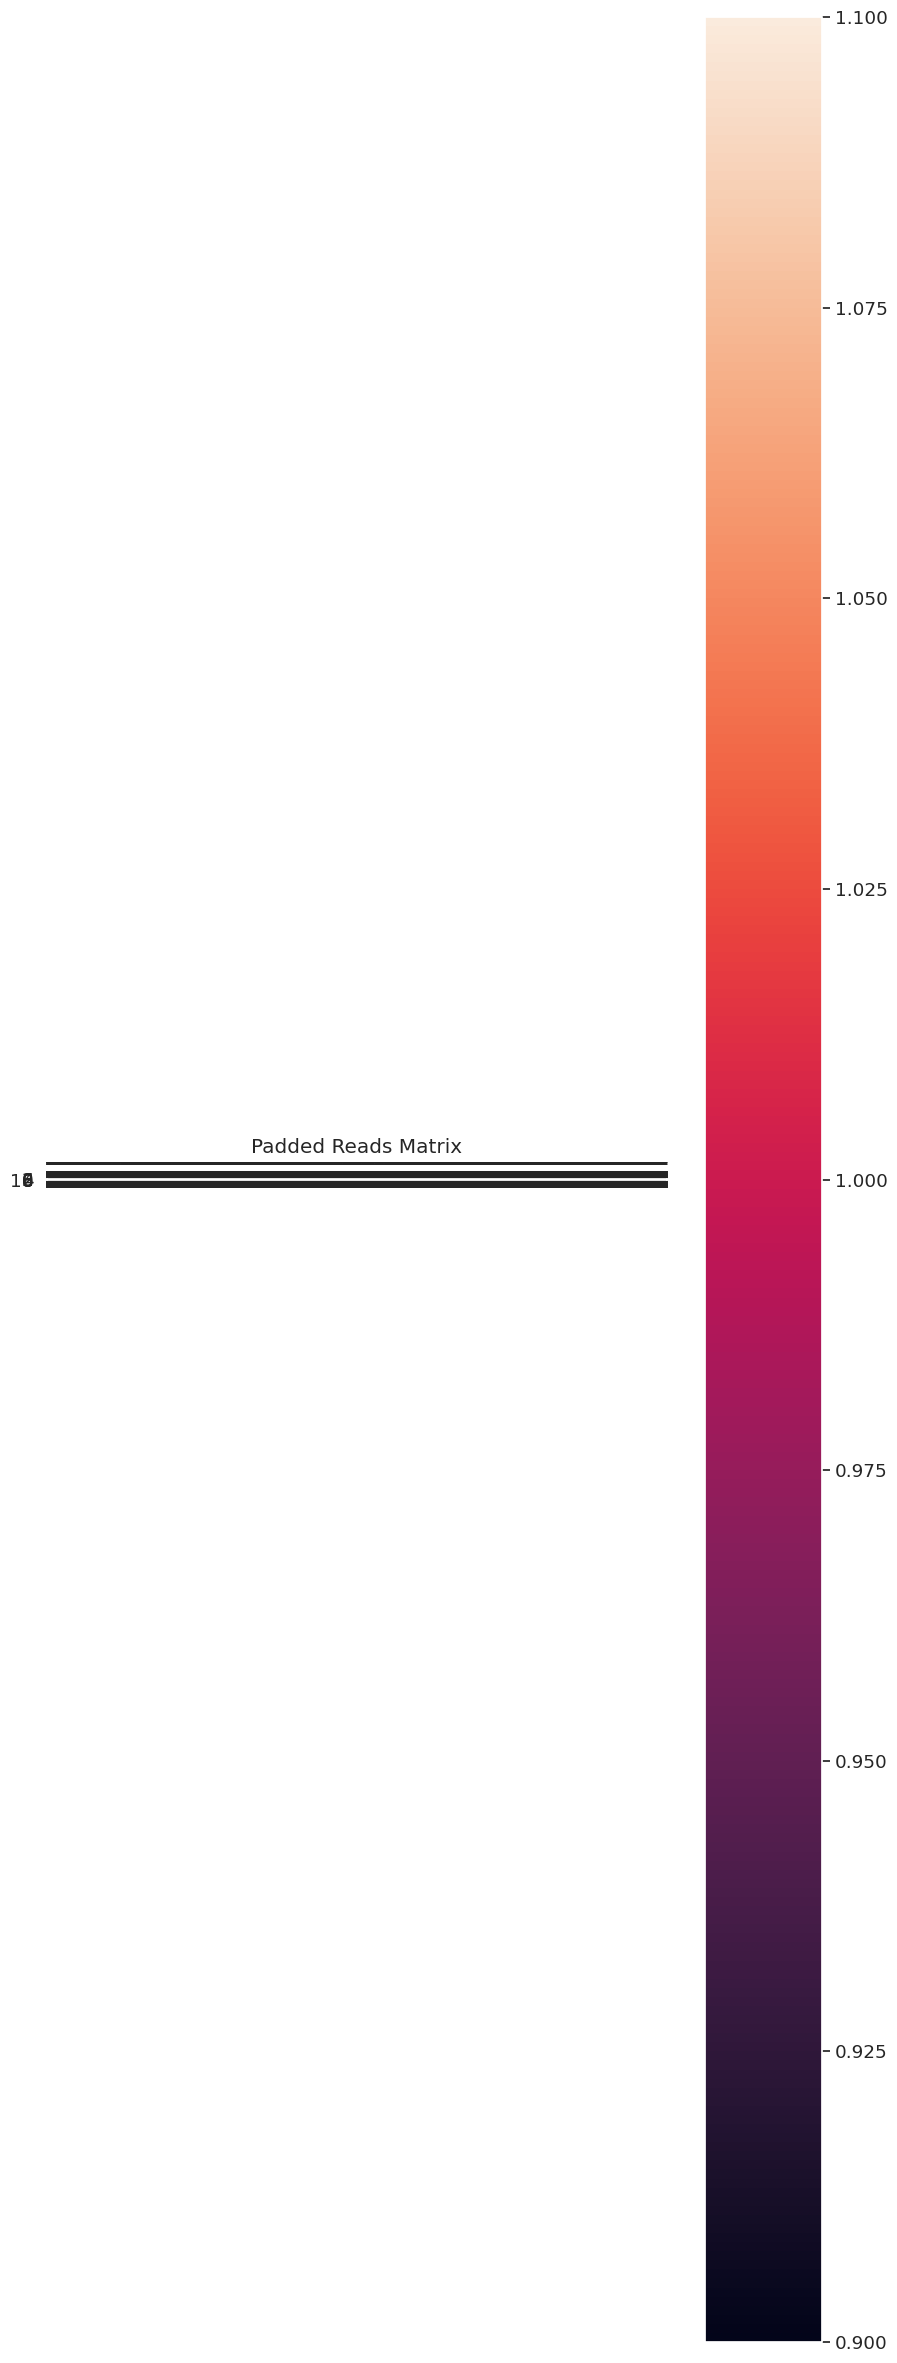

Padded reads saved to padded_reads_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-09-10.npy
Padded reads loaded successfully.


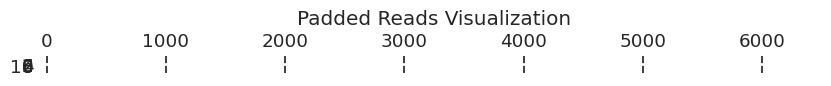

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

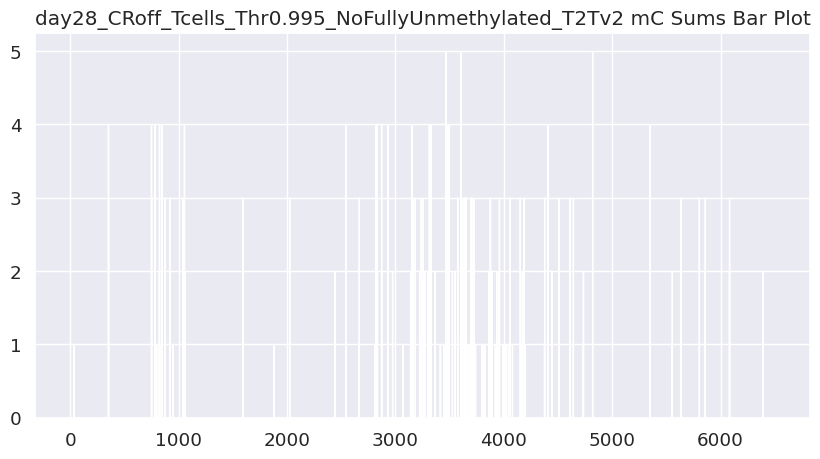

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


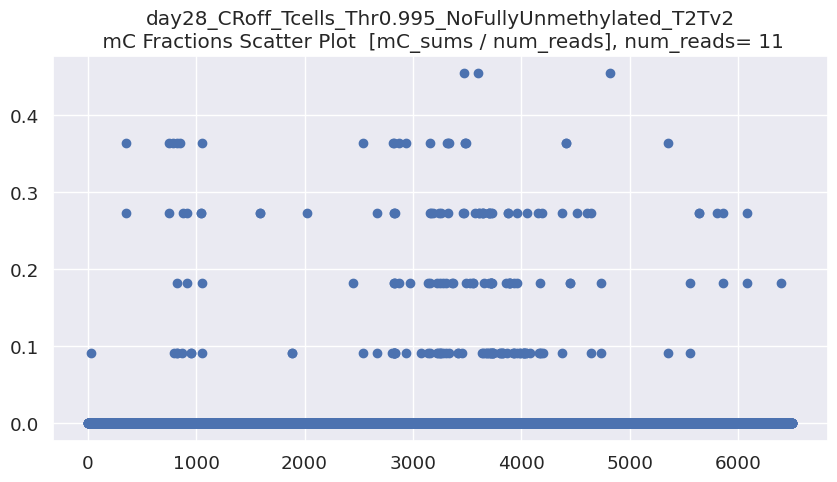

len(CGs_all) = 11
CGs_all.shape = (11, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


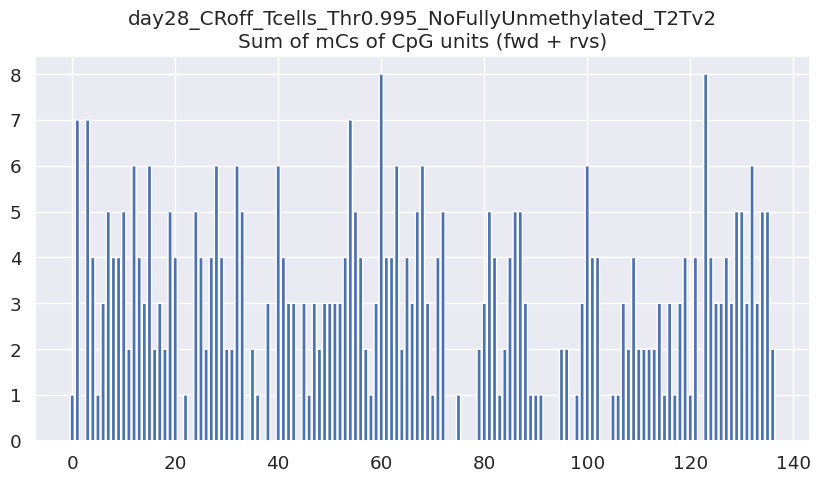

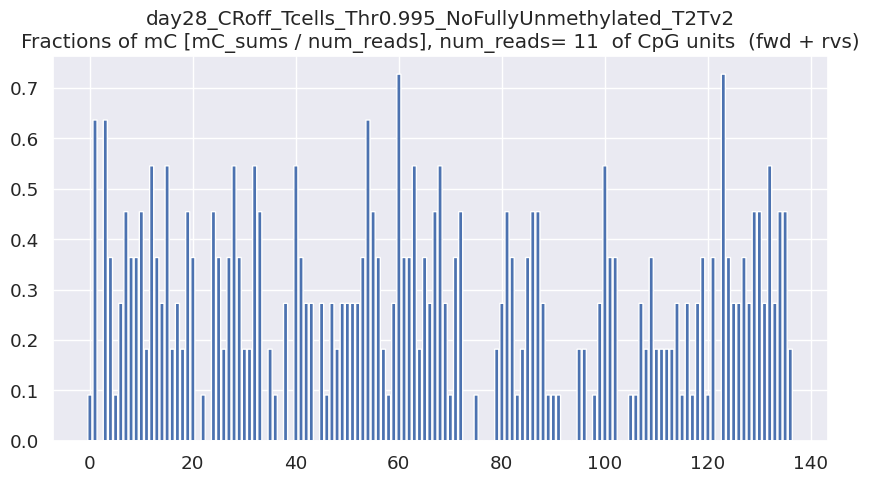

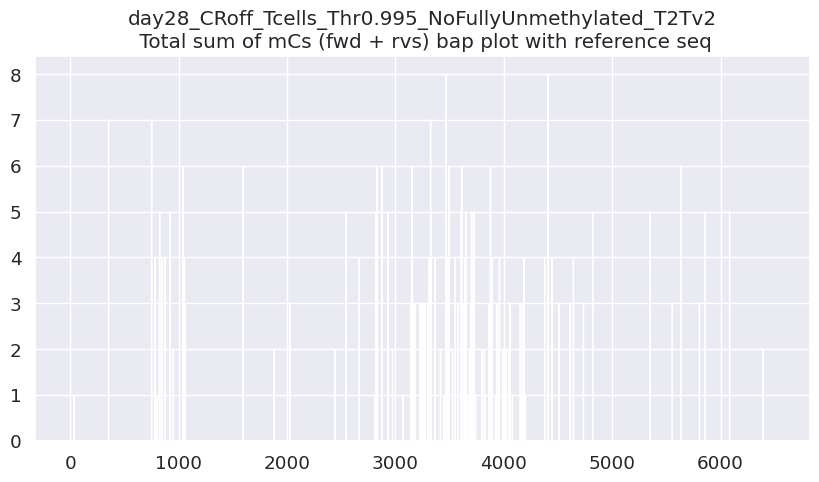

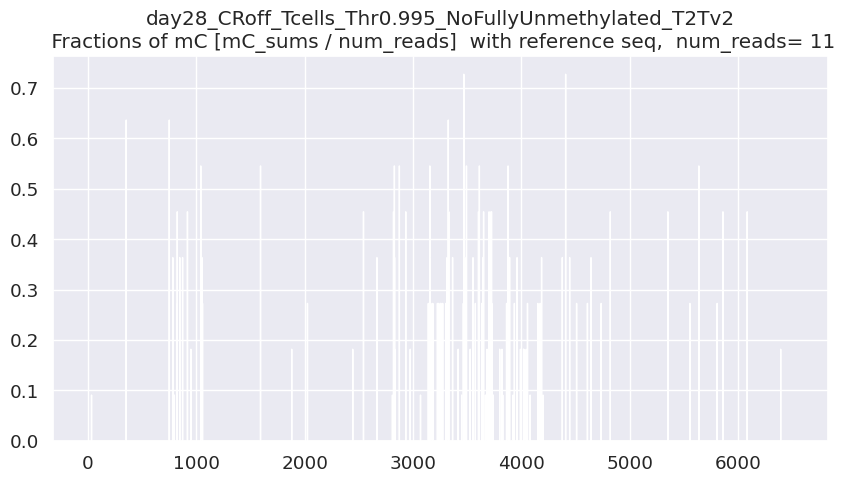

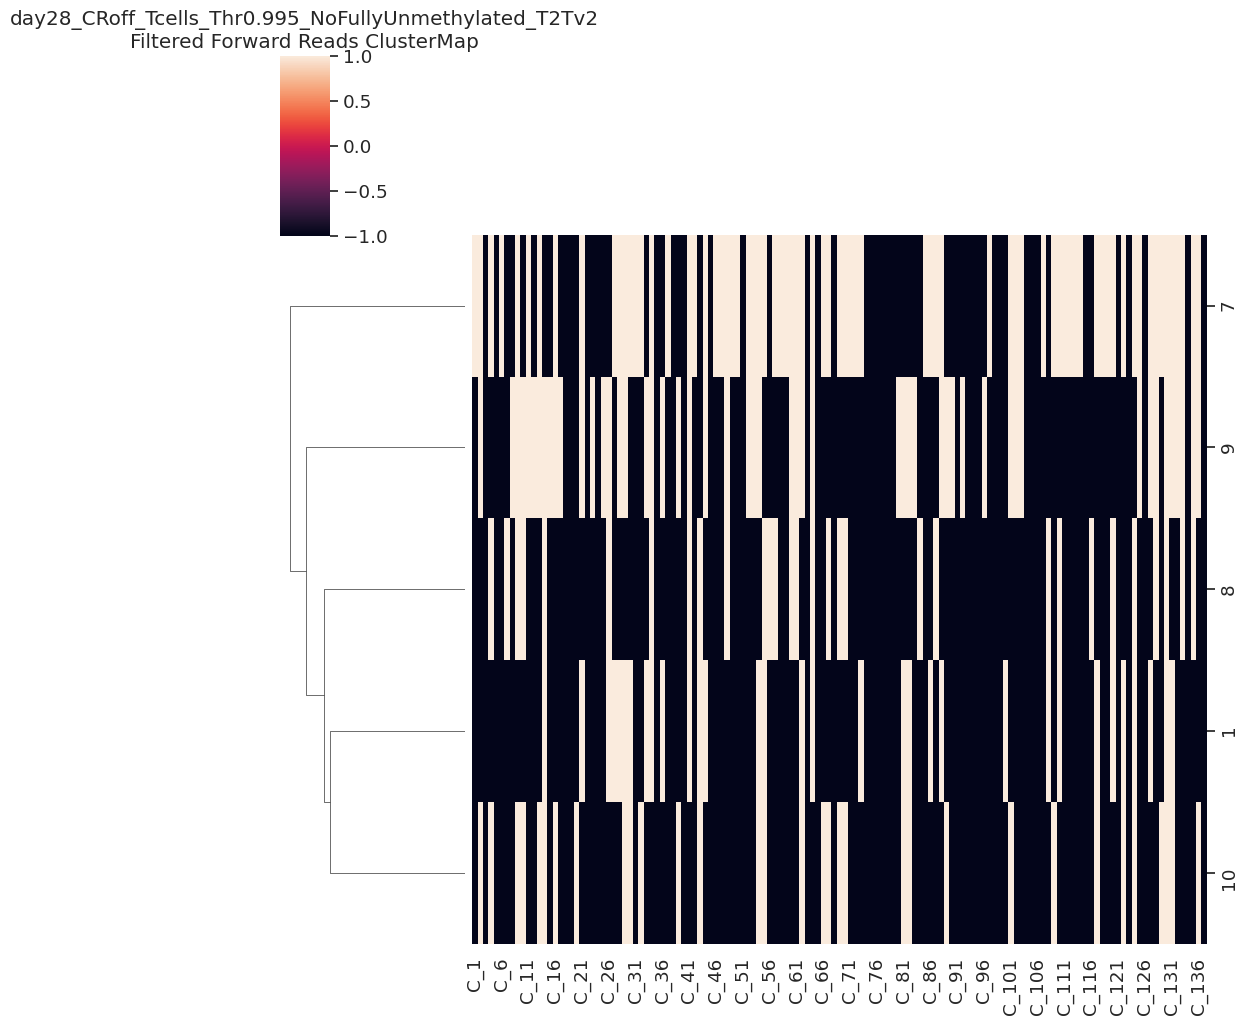

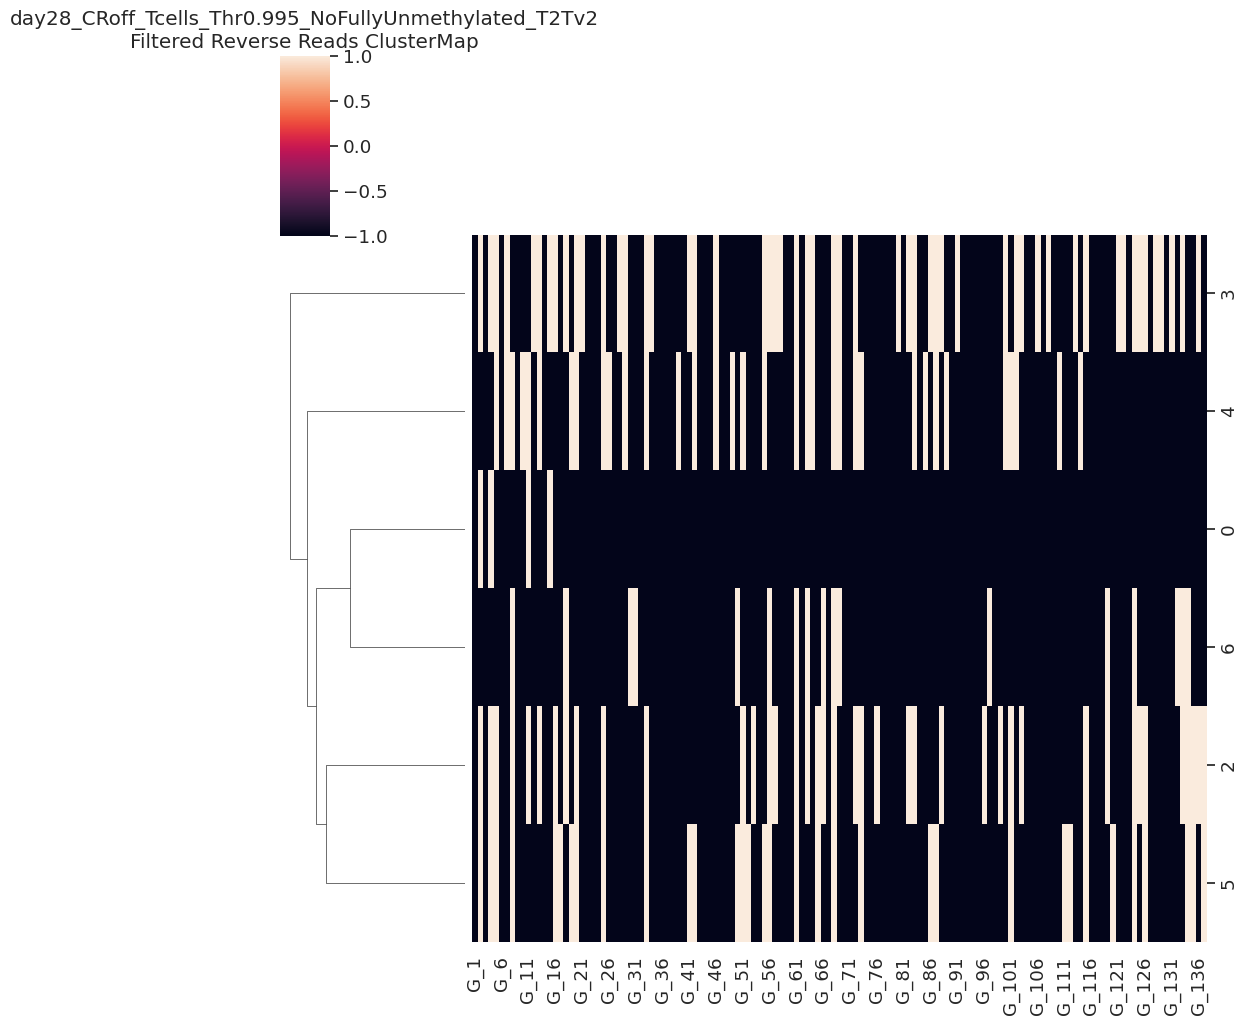

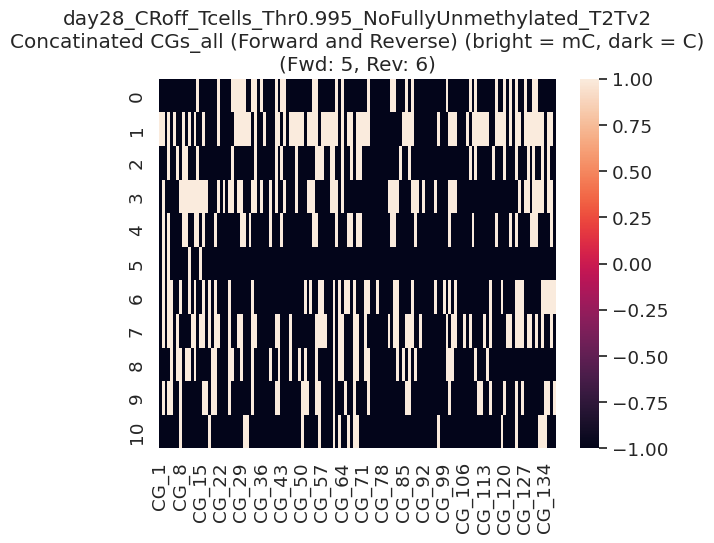

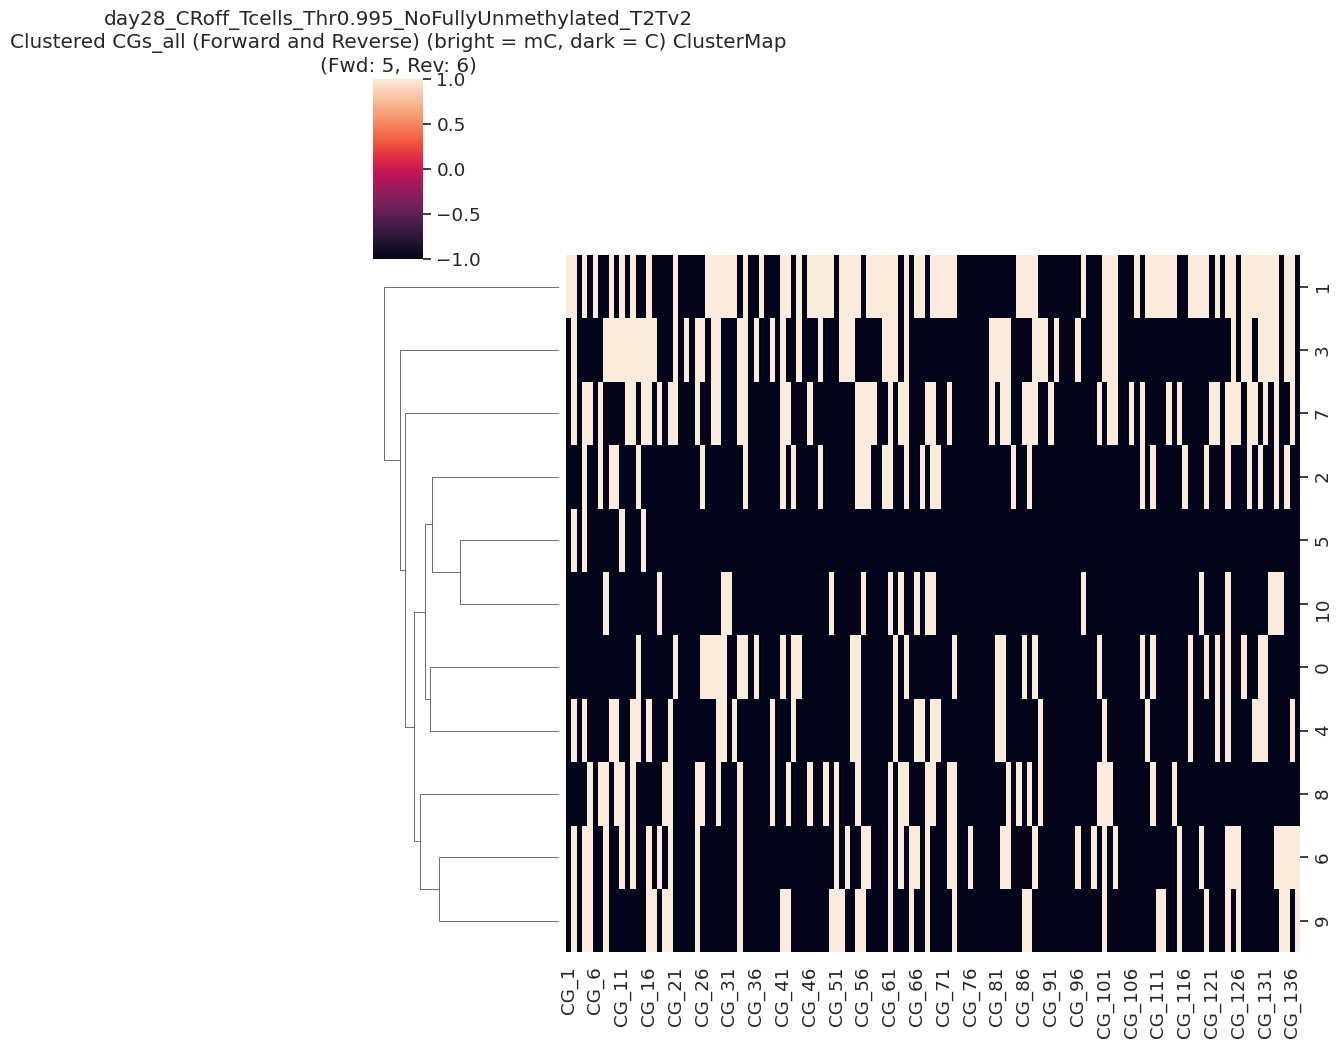

CGs_all saved as CG_137_padded_reads_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-09-10_units_combined_numFWD5_numRVS6.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [7]:
threshold_mC = 0.995 #0.7 #  0.9 #0.99

max_reads_plot = 3000

threshold_mapping_qualities=60 
threshold_avg_base_qualities=20

threshold_fraction_overlap_aligned = 0.9 # 0.1
threshold_fraction_mismatches = 0.7 # 0.5
# indel_fraction_threshold = 1  # 0.8
# non_fraction_threshold   = 1

# experiment_name = "day"+str(day_num)+"_unedited_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
experiment_name = "day"+str(day_num)+"_CRoff_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"

bam_path = original_bam_path #  unedit_bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    region=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, bam_path, region_str, 
        motifs, ref_seq_list, ref_genome_path=ref_genome_path, 
        experiment_name=experiment_name, output_dir=output_dir, 
        keep_full_coverage_reads_only=keep_full_coverage_reads_only,
        threshold_fraction_overlap_aligned=threshold_fraction_overlap_aligned,
        threshold_fraction_mismatches=threshold_fraction_mismatches,
        threshold_mapping_qualities=threshold_mapping_qualities, 
        threshold_avg_base_qualities=threshold_avg_base_qualities,
        max_reads_plot=max_reads_plot)
        # indel_fraction_threshold=indel_fraction_threshold, 
        # non_fraction_threshold=non_fraction_threshold)
        
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


In [8]:
reads_df

,read_name_str,read_name,read_id_number,mod,pos,read_lengths,mapping_qualities,avg_base_qualities,num_overlap_aligned_bases,fraction_overlap_aligned,num_nones,fraction_nones,num_inserts,fraction_inserts,num_mismatches,fraction_mismatches,num_ambiguous,pos_shifted
0,26691903-e686-4670-a760-ad70b0f87b42,1,1,"CG,0",-2897,6790,60,24.387482,6404,0.985231,102,0.015022,110,0.016200,48,0.007069,0,353
1,26691903-e686-4670-a760-ad70b0f87b42,1,1,"CG,0",-2500,6790,60,24.387482,6404,0.985231,102,0.015022,110,0.016200,48,0.007069,0,750
2,26691903-e686-4670-a760-ad70b0f87b42,1,1,"CG,0",-2332,6790,60,24.387482,6404,0.985231,102,0.015022,110,0.016200,48,0.007069,0,918
3,26691903-e686-4670-a760-ad70b0f87b42,1,1,"CG,0",-2193,6790,60,24.387482,6404,0.985231,102,0.015022,110,0.016200,48,0.007069,0,1057
4,c758517d-05c4-4357-8457-6526c65c72a0,2,2,"CG,0",-2897,6766,60,26.344073,6436,0.990154,64,0.009459,50,0.007390,30,0.004434,0,353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,30258949-6bba-40d0-a628-978b9f04ae14,21,21,"CG,0",921,6768,60,22.379580,6352,0.977231,151,0.022311,149,0.022015,86,0.012707,0,4171
452,30258949-6bba-40d0-a628-978b9f04ae14,21,21,"CG,0",1157,6768,60,22.379580,6352,0.977231,151,0.022311,149,0.022015,86,0.012707,0,4407
453,30258949-6bba-40d0-a628-978b9f04ae14,21,21,"CG,0",2304,6768,60,22.379580,6352,0.977231,151,0.022311,149,0.022015,86,0.012707,0,5554
454,30258949-6bba-40d0-a628-978b9f04ae14,21,21,"CG,0",2386,6768,60,22.379580,6352,0.977231,151,0.022311,149,0.022015,86,0.012707,0,5636


(array([3., 0., 3., 1., 2., 0., 0., 1., 0., 1.]),
 array([0.00325299, 0.00456823, 0.00588346, 0.0071987 , 0.00851393,
        0.00982917, 0.0111444 , 0.01245964, 0.01377487, 0.01509011,
        0.01640534]),
 <BarContainer object of 10 artists>)

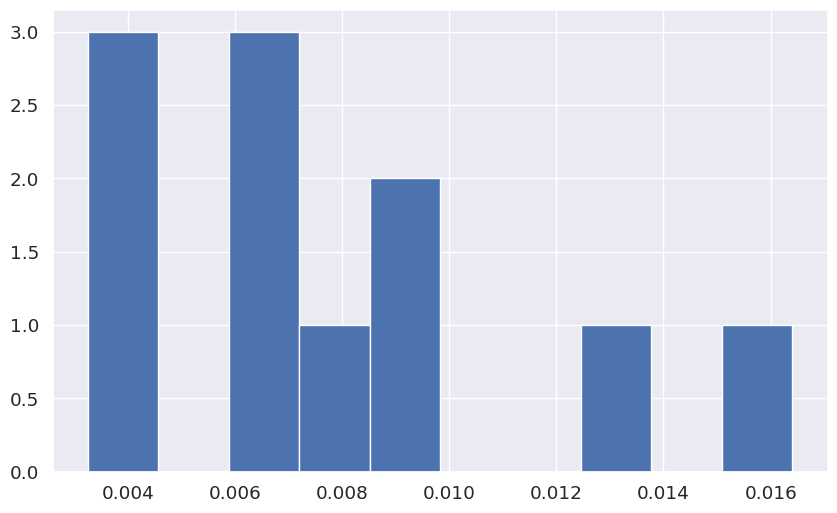

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(np.unique(reads_df['fraction_mismatches']))

(array([1., 1., 1., 0., 0., 0., 3., 1., 1., 3.]),
 array([0.974     , 0.97569231, 0.97738462, 0.97907692, 0.98076923,
        0.98246154, 0.98415385, 0.98584615, 0.98753846, 0.98923077,
        0.99092308]),
 <BarContainer object of 10 artists>)

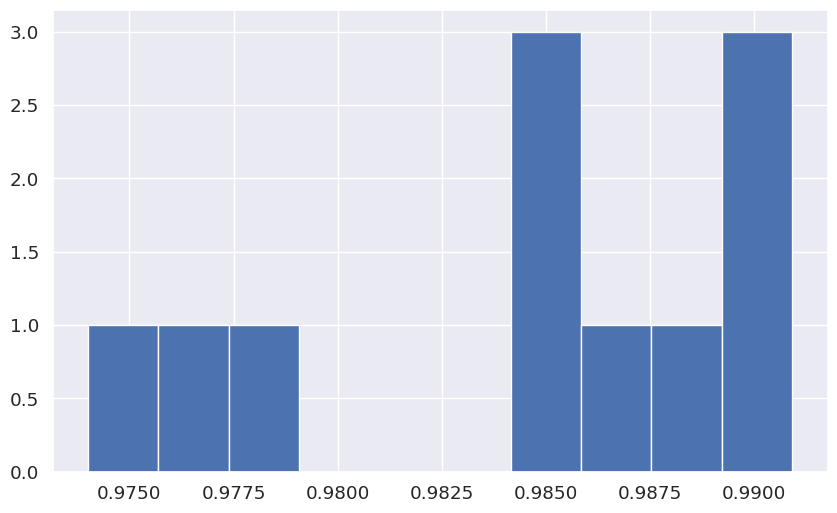

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(np.unique(reads_df['fraction_overlap_aligned']))

In [11]:
np.unique(reads_df['num_nones'])

array([ 59,  64,  71,  76,  89, 102, 103, 104, 151, 152, 180])

In [ ]:
# np.unique(reads_df['num_indels'])

In [ ]:
# np.unique(reads_df['nones_fraction'])

In [ ]:
# np.unique(reads_df['indel_fraction'])

In [ ]:
reads_df

In [ ]:
reads_df.shape

# Threshold 80%*mean(mC in alll reads)

In [ ]:
threshold_percent = 80
filtered_reads_df, methylation_counts, remove_reads_df = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

In [ ]:
remove_reads_df

In [ ]:
bam_path

In [ ]:
!pwd

In [ ]:
# output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
removed_reads_bam_name = "reads_with_mC_less_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
removed_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
removed_output_bam_path

In [ ]:
subset_BAM_by_read_IDs(original_bam_path, remove_reads_df, output_bam_path=removed_output_bam_path, index_output=True)


# Save filtered reads to BAM

In [ ]:
# output_dir_path = "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/outputs"
removed_reads_bam_name = "filtered_reads_with_mC_MORE_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
filtered_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
filtered_output_bam_path

In [ ]:
subset_BAM_by_read_IDs(original_bam_path, filtered_reads_df, output_bam_path=filtered_output_bam_path, index_output=True)


In [ ]:
sam_path = bam_to_sam(filtered_output_bam_path, sam_path=None)
sam_path

In [ ]:
# sam_path = bam_to_sam(removed_output_bam_path, sam_path=None)
# sam_path
# removed_reads_bam_path = '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [ ]:

plot_bam_quality_metrics(removed_output_bam_path)

In [ ]:
plot_bam_quality_metrics(filtered_output_bam_path)

In [ ]:
plot_bam_quality_metrics(original_bam_path)

# Load BAM files

In [ ]:
# removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [ ]:
region_str

In [ ]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams


bam = removed_output_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)

In [ ]:


sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = filtered_output_bam_path  #  removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)



In [ ]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = original_bam_path #  unedit_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)


# Get read #27 start and end coordinates:

In [ ]:
import pysam

bam_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
with pysam.AlignmentFile(bam_path, "rb") as bamfile:
    for i, read in enumerate(bamfile):
        if i == 0:
            print(f"Read 0: {read.query_name}, start: {read.reference_start}, end: {read.reference_end}")
        if i == 16:
            print(f"Read 16: {read.query_name}, start: {read.reference_start}, end: {read.reference_end}")
            
        if i == 27:
            print(f"Read 27: {read.query_name}, start: {read.reference_start}, end: {read.reference_end}")
            break


In [ ]:

import pysam

bam_path = str(bam_path)  # Ensure bam_path is a string if it's a Path object

read_name = "a18a8888-b8f5-4be5-bd58-504a07241f92"

with pysam.AlignmentFile(bam_path, "rb") as bamfile:
    for i, read in enumerate(bamfile):
        if read.query_name == read_name:
            print(f"Read Index Number: {i}")
            print(f"Read name: {read.query_name}")
            print(f"Reference name: {bamfile.get_reference_name(read.reference_id)}")
            print(f"Start: {read.reference_start}")
            print(f"End: {read.reference_end}")
            print(f"Mapping quality:  {read.mapping_quality}")
            print(f"Is reverse: {read.is_reverse}")
            break

In [ ]:
get_read_info_by_index(original_bam_path, 0)

In [ ]:
get_read_info_by_name(original_bam_path, "a18a8888-b8f5-4be5-bd58-504a07241f92")

In [ ]:
get_read_info_by_index(original_bam_path, 923)

In [ ]:
206587329 - 206583354

In [ ]:
206589854 - 206588147

In [ ]:

region_str

In [ ]:
3335363 - 206583354

# Threshold 10%*mean(mC in alll reads)

In [ ]:
threshold_percent = 10
filtered_reads_df, methylation_counts, remove_reads_df = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

In [ ]:
remove_reads_df

In [ ]:
bam_path

In [ ]:
!pwd

In [ ]:
# output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
removed_reads_bam_name = "reads_with_mC_less_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
removed_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
removed_output_bam_path

In [ ]:
subset_BAM_by_read_IDs(original_bam_path, remove_reads_df, output_bam_path=removed_output_bam_path, index_output=True)


# Save filtered reads to BAM

In [ ]:
# output_dir_path = "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/outputs"
removed_reads_bam_name = "filtered_reads_with_mC_MORE_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
filtered_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
filtered_output_bam_path

In [ ]:
subset_BAM_by_read_IDs(original_bam_path, filtered_reads_df, output_bam_path=filtered_output_bam_path, index_output=True)


In [ ]:
sam_path = bam_to_sam(filtered_output_bam_path, sam_path=None)
sam_path

In [ ]:
# sam_path = bam_to_sam(removed_output_bam_path, sam_path=None)
# sam_path
# removed_reads_bam_path = '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [ ]:

plot_bam_quality_metrics(removed_output_bam_path)

In [ ]:
plot_bam_quality_metrics(filtered_output_bam_path)

In [ ]:
plot_bam_quality_metrics(original_bam_path)

# Load BAM files

In [ ]:
# removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [ ]:
region_str

In [ ]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams


bam = removed_output_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)

In [ ]:


sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = filtered_output_bam_path  #  removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)



In [ ]:
matrix

In [ ]:
meta

In [ ]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = original_bam_path # unedit_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)


# Threshold 5%*mean(mC in alll reads)

In [ ]:
threshold_percent = 5
filtered_reads_df, methylation_counts, remove_reads_df = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

In [ ]:
remove_reads_df

In [ ]:
bam_path

In [ ]:
!pwd

In [ ]:
# output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
removed_reads_bam_name = "reads_with_mC_less_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
removed_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
removed_output_bam_path

In [ ]:
subset_BAM_by_read_IDs(original_bam_path, remove_reads_df, output_bam_path=removed_output_bam_path, index_output=True)


# Save filtered reads to BAM

In [ ]:
# output_dir_path = "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/outputs"
removed_reads_bam_name = "filtered_reads_with_mC_MORE_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
filtered_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
filtered_output_bam_path

In [ ]:
subset_BAM_by_read_IDs(original_bam_path, filtered_reads_df, output_bam_path=filtered_output_bam_path, index_output=True)


In [ ]:
sam_path = bam_to_sam(filtered_output_bam_path, sam_path=None)
sam_path

In [ ]:
# sam_path = bam_to_sam(removed_output_bam_path, sam_path=None)
# sam_path
# removed_reads_bam_path = '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [ ]:

plot_bam_quality_metrics(removed_output_bam_path)

In [ ]:
plot_bam_quality_metrics(filtered_output_bam_path)

In [ ]:
plot_bam_quality_metrics(original_bam_path)

# Load BAM files

In [ ]:
# removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [ ]:
region_str

In [ ]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams


bam = removed_output_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)

In [ ]:


sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = filtered_output_bam_path  #  removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)



In [ ]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = original_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)
